# ACP Project - Model Evaluation

## Setup

In [1]:
import warnings, pickle, os
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 300)

from IPython.display import display
import matplotlib.pyplot as plt

import seaborn as sns

import shap
import optuna

%load_ext autoreload
%autoreload 1

In [2]:
from utils.evaluation import f2_score, METRICS, evaluate, evaluate_from_pred, with_sampling_strategies, spotCheckCV, spotCheckDatasets, F2TabNet, joint_plot
from utils.isolation_forest_wrapper import IsolationForestWrapper
%aimport utils.evaluation

In [3]:
from hyperparameter_tuning import tune_xgboost, tune_tabnet, tune_lgbm, tune_randomforest, tune_isolationforest, tune_logisticregression
%aimport hyperparameter_tuning

In [4]:
class Notebook:
    IMAGE_DIR = "images/critical_event_24_missing_values"
    MODEL_DIR = "models/critical_event_24_missing_values"
    OUTCOME = "CriticalEvent"
    OUTCOME_WITHIN = 1

    SAVE_MODELS = True
    SAVE_IMAGES = True

    RUN_HYPERPARAMETERS = True
    HYPERPARAMETER_TIMEOUT = 60 * 60
    HYPERPARAMETER_NJOBS = 4

    SHAP_PLOTS_MAXDISPLAY = 20
    EVAL_N_RESAMPLES = 9999

    MODELS = {}
    EXPLAINERS = {}
    EVAL_RESULTS = {}
    TUNED_RESULTS = {}
    MORTALITY_RESULTS = {}
    CRITICALCARE_RESULTS = {}


In [5]:
try:
    os.makedirs(Notebook.IMAGE_DIR)
    os.makedirs(Notebook.MODEL_DIR)
except FileExistsError:
    pass


In [6]:
def restore():
    with open(f"{Notebook.MODEL_DIR}/models.bin", "rb") as file:
        Notebook.MODELS = pickle.load(file)

    with open(f"{Notebook.MODEL_DIR}/explainers.bin", "rb") as file:
        Notebook.EXPLAINERS = pickle.load(file)


### Dataset

In [7]:
from dataset import SCIData, SCICols
from utils.data_profiling import ensure_categorical_overlap, drop_exclusive_cols
%aimport dataset, utils.data_profiling

sci = (
    SCIData.load('data/sci_processed.h5')
    .fix_readmissionband()
    .derive_critical_event(within=Notebook.OUTCOME_WITHIN, return_subcols=True)
)
Notebook.OUTCOME = 'CriticalEvent'


In [8]:
from sklearn.model_selection import train_test_split

scii = (
    SCIData(sci.sort_values("AdmissionDateTime"))
    .omit_redundant()
    .drop(["ReadmissionBand", "AgeBand", "LastSpecialty"], axis=1)
    .omit_ae()
    .raw_news()
    .mandate_news()
    .augment_hsmr()
)

sci_train, sci_test = train_test_split(
    scii, test_size=0.33, random_state=42, shuffle=False
)
y_test_mortality, y_test_criticalcare = (
    sci_test.DiedWithinThreshold.copy(),
    sci_test.CriticalCare.copy(),
)

if Notebook.OUTCOME == "CriticalEvent":
    sci_train, sci_test = (
        sci_train.drop(
            ["DiedWithinThreshold", "CriticalCare"], axis=1, errors="ignore"
        ),
        sci_test.drop(["DiedWithinThreshold", "CriticalCare"], axis=1, errors="ignore"),
    )

sci_train, sci_test = SCIData(sci_train), SCIData(sci_test)

# Drop HSMR_15 as there is only 1 in the entire dataset, making a split impossible
(X_train, y_train), (X_test, y_test) = (
    sci_train.impute_blood()
    .encode_ccs_onehot()
    .xy(outcome=Notebook.OUTCOME, ordinal_encoding=True, dropna=False, fillna=True),
    sci_test.impute_blood()
    .encode_ccs_onehot()
    .xy(outcome=Notebook.OUTCOME, ordinal_encoding=True, dropna=False, fillna=True),
)
categorical_cols_idx, categorical_cols_dims = X_train.describe_categories()
drop_exclusive_cols(X_train, X_test)
ensure_categorical_overlap(X_train, X_test, categorical_cols_idx)

# Mandated vitals, Categorical diagnoses (main only)
(X_train_if, y_train_if), (X_test_if, y_test_if) = (
    sci_train.drop(SCICols.diagnoses[1:], axis=1).xy(
        outcome=Notebook.OUTCOME, ordinal_encoding=True, fillna=True
    ),
    sci_test.drop(SCICols.diagnoses[1:], axis=1).xy(
        outcome=Notebook.OUTCOME, ordinal_encoding=True, fillna=True
    ),
)
drop_exclusive_cols(X_train_if, X_test_if)

(X_train_lgbm, y_train_lgbm), (X_test_lgbm, y_test_lgbm) = (
    sci_train.encode_ccs_onehot().xy(
        outcome=Notebook.OUTCOME, ordinal_encoding=True, fillna=False
    ),
    sci_test.encode_ccs_onehot().xy(
        outcome=Notebook.OUTCOME, ordinal_encoding=True, fillna=False
    ),
)
drop_exclusive_cols(X_train_lgbm, X_test_lgbm)
ensure_categorical_overlap(X_train_lgbm, X_test_lgbm, categorical_cols_idx)

(X_train_tn, X_valid_tn, y_train_tn, y_valid_tn) = train_test_split(
    X_train.to_numpy(),
    y_train.to_numpy(),
    stratify=y_train,
    test_size=0.33,
    random_state=42,
)

(X_train_news, y_train_news), (X_test_news, y_test_news) = (
    sci_train.xy(
        outcome=Notebook.OUTCOME, x=SCICols.news_data_raw, dtype=float, fillna=True
    ),
    sci_test.xy(
        outcome=Notebook.OUTCOME, x=SCICols.news_data_raw, dtype=float, fillna=True
    ),
)
drop_exclusive_cols(X_train_news, X_test_news)


### Tuning

In [9]:
from sklearn.metrics import precision_recall_curve


def get_threshold(y_train, y_pred_proba, target=0.85):
    """ Given prediction probabilities, sets the prediction threshold to approach the given target recall
    """

    # Get candidate thresholds from the model, and find the one that gives the best fbeta score
    precision, recall, thresholds = precision_recall_curve(y_train, y_pred_proba)
    closest = thresholds[np.abs(recall - target).argmin()]

    return closest


## Models

### Baseline (NEWS)

Accuracy  Precision   Recall  F1 Score  F2 Score      AUC       AUC_CI
Model  0.979539   0.129032  0.35023  0.188586   0.26081  0.83729  0.805-0.868

array([[31234,   513],
       [  141,    76]])

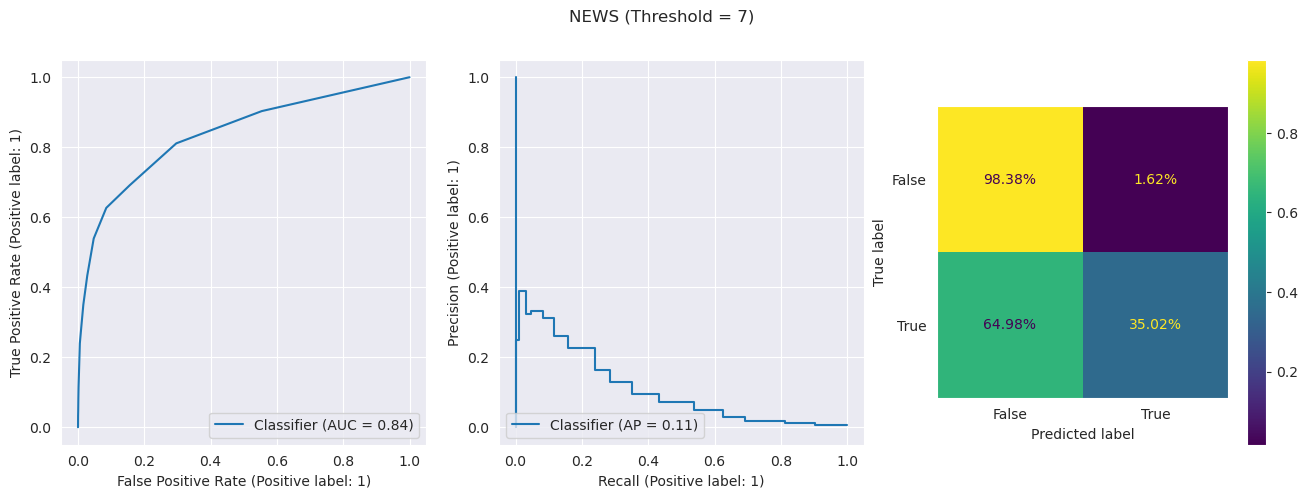

In [10]:
baseline_mask = sci[sci.c_NEWS_score.notna()].index.intersection(sci_test.index)
Notebook.EVAL_RESULTS["Baseline (NEWS)"] = evaluate_from_pred(
    y_test.loc[baseline_mask],
    y_pred=(sci.loc[baseline_mask].c_NEWS_score >= 7),
    y_pred_proba=(sci.loc[baseline_mask].c_NEWS_score),
    plot_title="NEWS (Threshold = 7)",
    save=f"{Notebook.IMAGE_DIR}/baseline_news.png" if Notebook.SAVE_IMAGES else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


Mortality


Accuracy  Precision  Recall  F1 Score  F2 Score       AUC       AUC_CI
Model  0.982699   0.106961     0.7  0.185567  0.331928  0.952171  0.926-0.973

array([[31348,   526],
       [   27,    63]])

Critical Care


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.978538   0.033956  0.145985  0.055096  0.087951  0.771084   

            AUC_CI  
Model  0.726-0.814

array([[31258,   569],
       [  117,    20]])

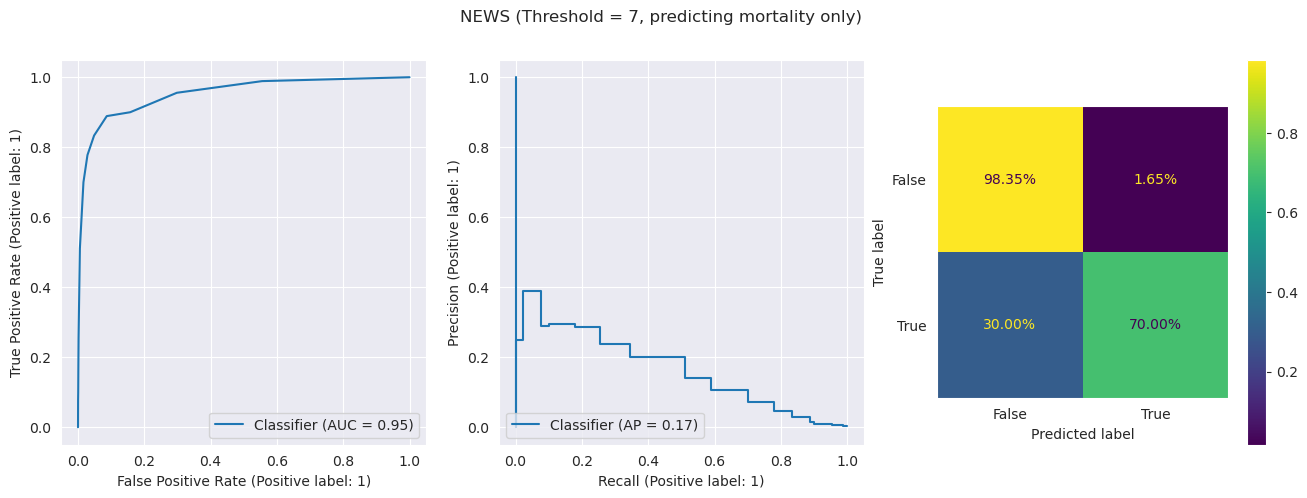

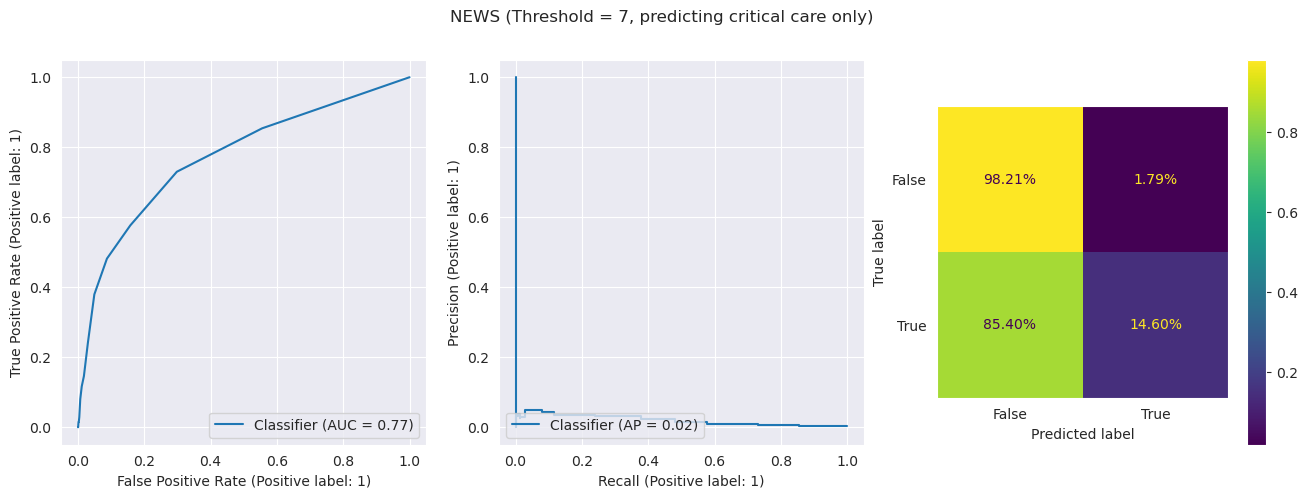

In [11]:
print("Mortality")
Notebook.MORTALITY_RESULTS["Baseline (NEWS)"] = evaluate_from_pred(
    y_test_mortality.loc[baseline_mask],
    y_pred=(sci.loc[baseline_mask].c_NEWS_score >= 7),
    y_pred_proba=(sci.loc[baseline_mask].c_NEWS_score),
    plot_title="NEWS (Threshold = 7, predicting mortality only)",
    save=f"{Notebook.IMAGE_DIR}/baseline_news_mortality.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)

print("Critical Care")
Notebook.CRITICALCARE_RESULTS["Baseline (NEWS)"] = evaluate_from_pred(
    y_test_criticalcare.loc[baseline_mask],
    y_pred=(sci.loc[baseline_mask].c_NEWS_score >= 7),
    y_pred_proba=(sci.loc[baseline_mask].c_NEWS_score),
    plot_title="NEWS (Threshold = 7, predicting critical care only)",
    save=f"{Notebook.IMAGE_DIR}/baseline_news_criticalcare.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)



### Logistic Regression (NEWS only)

Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.866162   0.034182  0.686636  0.065122  0.142529  0.837522   

            AUC_CI  
Model  0.804-0.869

array([[27537,  4210],
       [   68,   149]])

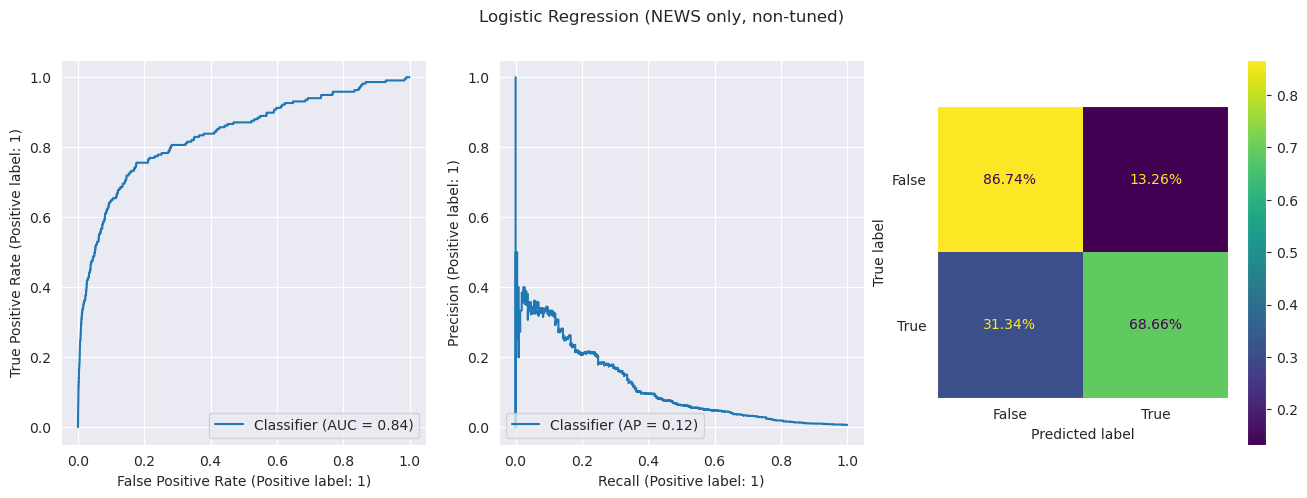

In [12]:
from sklearn.linear_model import LogisticRegression

modelkey = "Logistic Regression (NEWS only)"
model = LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42).fit(
    X_train_news, y_train_news
)
Notebook.MODELS[modelkey] = model

Notebook.EVAL_RESULTS[modelkey] = evaluate(
    model,
    X_test_news,
    y_test_news,
    plot_title="Logistic Regression (NEWS only, non-tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_logistic_news.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.534382   0.012498  0.866359  0.024641  0.059082  0.837522   

            AUC_CI  
Model  0.804-0.869

array([[16893, 14854],
       [   29,   188]])

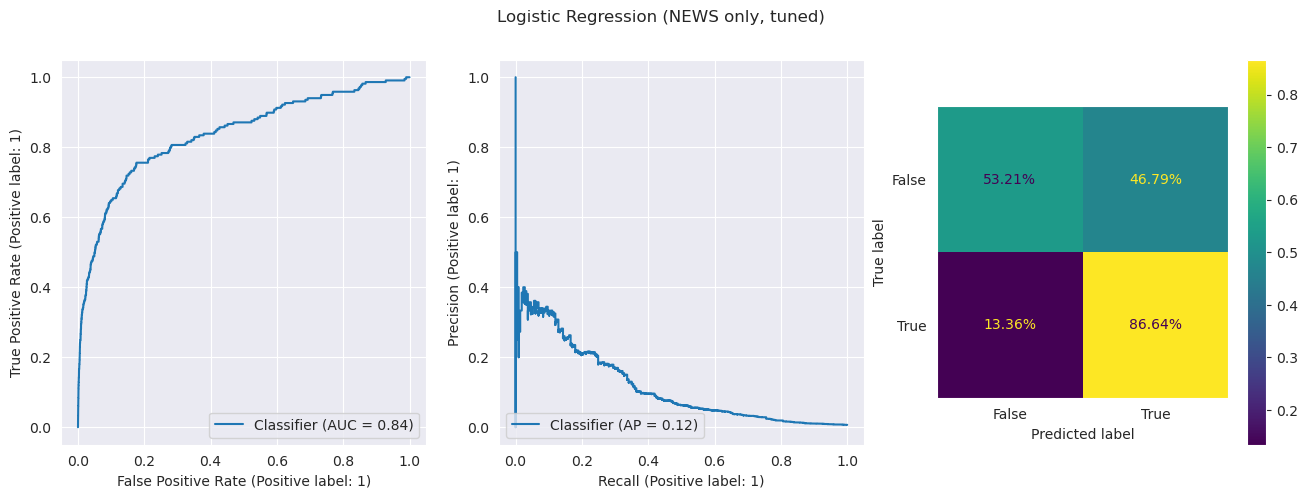

In [13]:
threshold = get_threshold(y_train_news, model.predict_proba(X_train_news)[:, 1],)

y_pred_proba = model.predict_proba(X_test_news)[:, 1]
y_pred = np.where(y_pred_proba > threshold, 1, 0)

Notebook.TUNED_RESULTS[modelkey] = evaluate_from_pred(
    y_test_news,
    y_pred,
    y_pred_proba,
    plot_title="Logistic Regression (NEWS only, tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_thresholded_logistic_news.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)



Mortality


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.532036   0.005784  0.966667  0.011499  0.028243  0.931502   

            AUC_CI  
Model  0.893-0.964

array([[16919, 14955],
       [    3,    87]])

Critical Care


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.532067   0.007379  0.810219  0.014625    0.0356  0.784876   

            AUC_CI  
Model  0.741-0.826

array([[16896, 14931],
       [   26,   111]])

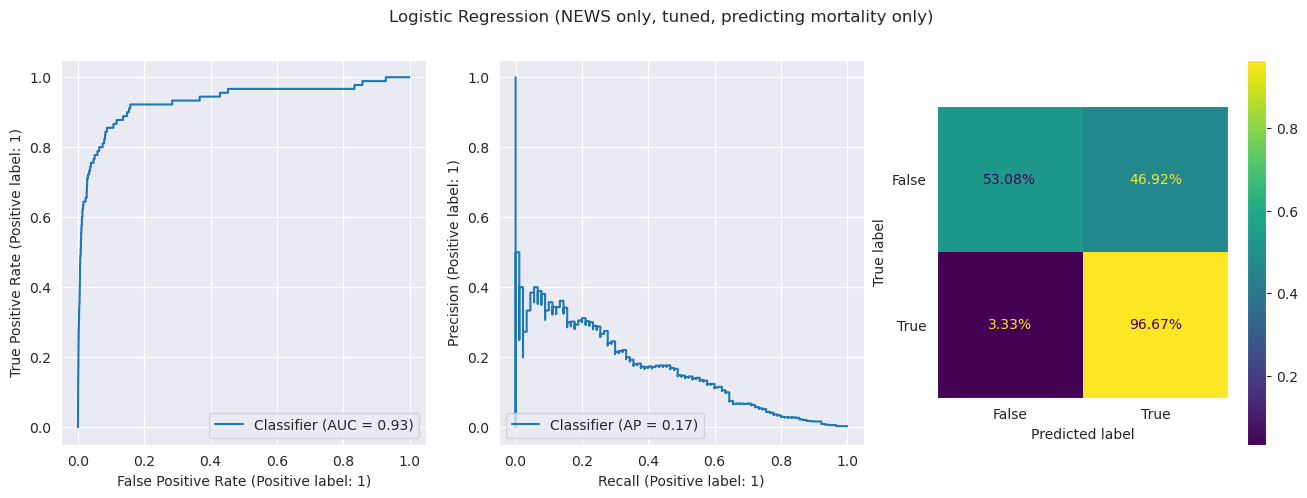

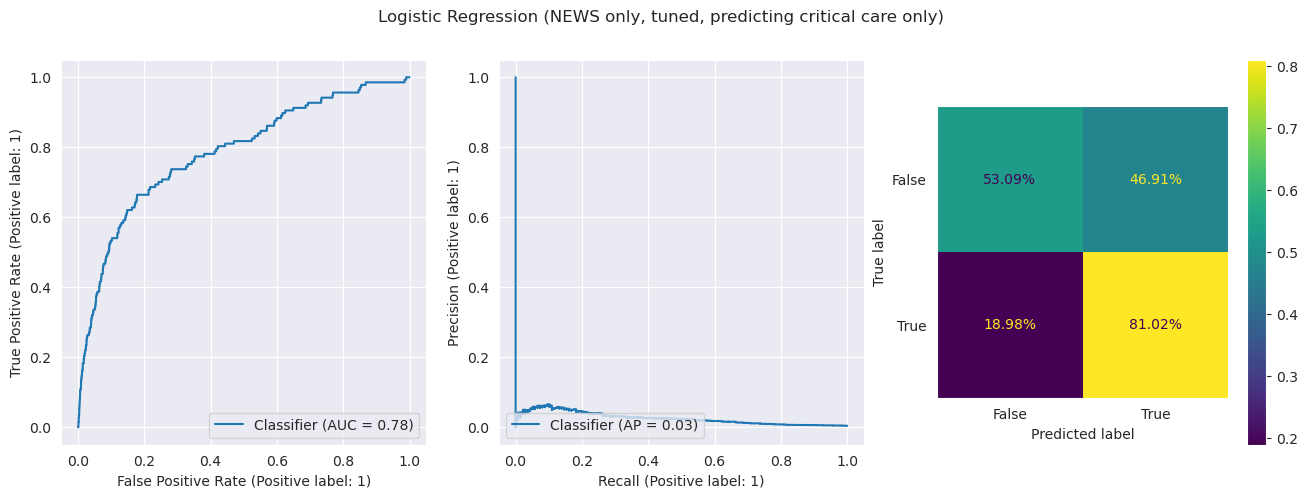

In [14]:
print("Mortality")
Notebook.MORTALITY_RESULTS[modelkey] = evaluate_from_pred(
    y_test_mortality,
    y_pred,
    y_pred_proba,
    plot_title="Logistic Regression (NEWS only, tuned, predicting mortality only)",
    save=f"{Notebook.IMAGE_DIR}/eval_mortality_thresholded_logistic_news.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)

print("Critical Care")
Notebook.CRITICALCARE_RESULTS[modelkey] = evaluate_from_pred(
    y_test_criticalcare,
    y_pred,
    y_pred_proba,
    plot_title="Logistic Regression (NEWS only, tuned, predicting critical care only)",
    save=f"{Notebook.IMAGE_DIR}/eval_criticalcare_thresholded_logistic_news.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

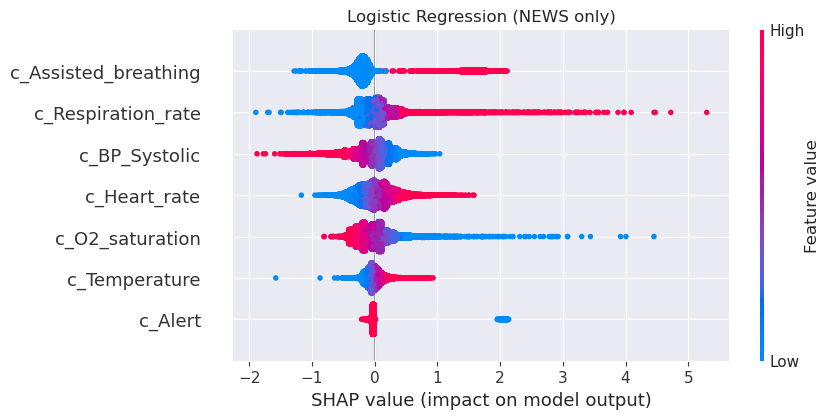

In [15]:
explainer = shap.LinearExplainer(
    model, X_train_news, feature_perturbation="correlation_dependent"
)
shap_values = explainer(X_test_news)
Notebook.EXPLAINERS[modelkey] = (explainer, shap_values)

fig = shap.plots.beeswarm(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("Logistic Regression (NEWS only)")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_swarm_logistic_regression_news.png",
        bbox_inches="tight",
    )


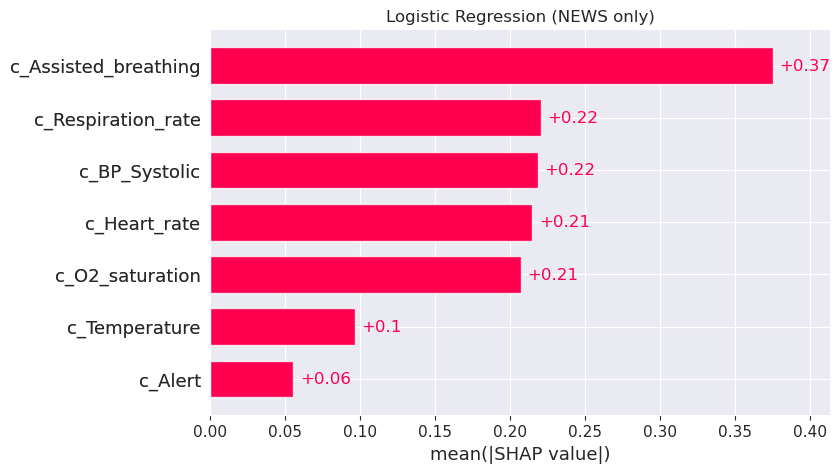

In [16]:
fig = shap.plots.bar(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("Logistic Regression (NEWS only)")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_bar_logistic_regression_news.png",
        bbox_inches="tight",
    )


### Logistic Regression

In [17]:
lr_params = {
    "LR__max_iter": 10000,
    "LR__penalty": "l2",
    "LR__solver": "lbfgs",
    "LR__C": 7.87,
    "LR__class_weight": "balanced",
    "IMB__sampling_strategy": 0.2,
}

if Notebook.RUN_HYPERPARAMETERS:
    lr_params.update(
        tune_logisticregression(
            X_train,
            y_train,
            timeout=Notebook.HYPERPARAMETER_TIMEOUT,
            n_jobs=Notebook.HYPERPARAMETER_NJOBS,
        )
    )


BEST PARAMETERS
{'LR__penalty': 'l2', 'LR__C': 1.7248915874378539, 'LR__class_weight': None, 'IMB__sampling_strategy': 0.11659105816775356}


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.978319   0.163842  0.534562  0.250811   0.36802  0.920145   

            AUC_CI  
Model  0.898-0.941

array([[31155,   592],
       [  101,   116]])

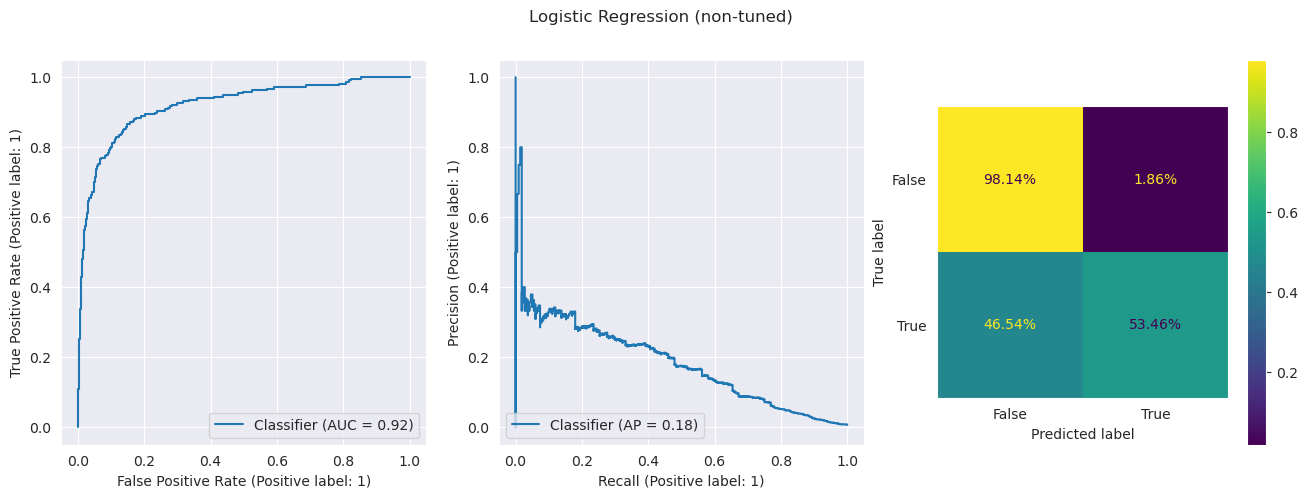

In [18]:
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

modelkey = "Logistic Regression"
model = (
    ImbPipeline(steps=[("IMB", RandomUnderSampler()), ("LR", LogisticRegression()),])
    .set_params(**lr_params)
    .fit(X_train, y_train)
)

Notebook.EVAL_RESULTS[modelkey] = evaluate(
    model,
    X_test,
    y_test,
    plot_title="Logistic Regression (non-tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_logistic_regression.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)

Notebook.MODELS[modelkey] = model


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.854023   0.038581  0.857143  0.073839  0.163473  0.920145   

            AUC_CI  
Model  0.898-0.941

array([[27112,  4635],
       [   31,   186]])

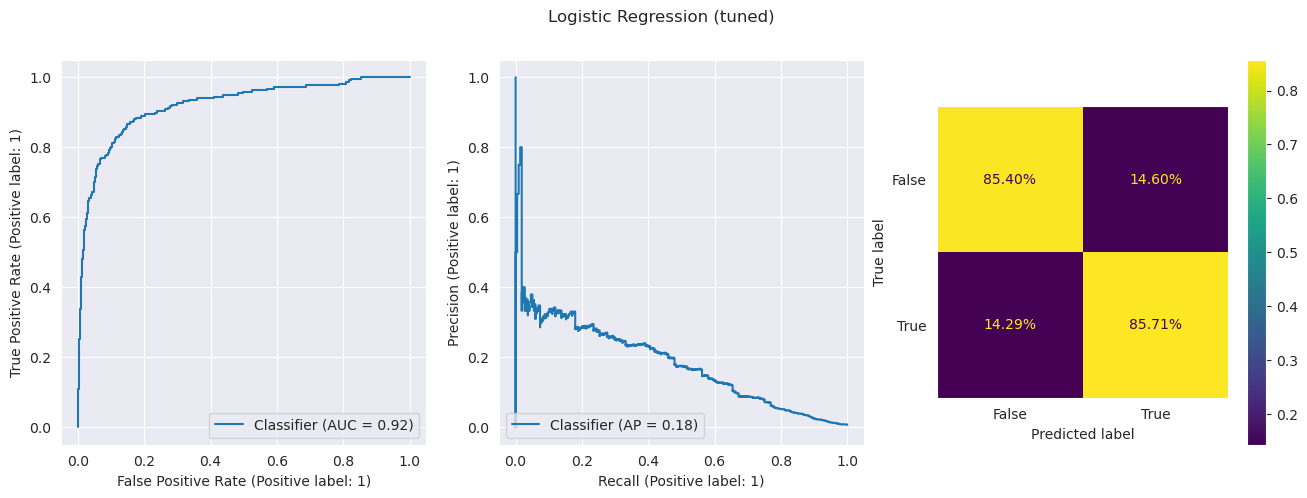

In [19]:
threshold = get_threshold(y_train, model.predict_proba(X_train)[:, 1],)

# Create predictions on the test set, using this new threshold
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = np.where(y_pred_proba > threshold, 1, 0)

# Produce scores
Notebook.TUNED_RESULTS[modelkey] = evaluate_from_pred(
    y_test,
    y_pred,
    y_pred_proba,
    plot_title="Logistic Regression (tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_thresholded_logistic_regression.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


Mortality


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.851239   0.016179  0.866667  0.031765  0.075275  0.933575   

            AUC_CI  
Model  0.904-0.959

array([[27131,  4743],
       [   12,    78]])

Critical Care


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.852271   0.024476  0.861314    0.0476   0.10989  0.914339   

            AUC_CI  
Model  0.884-0.942

array([[27124,  4703],
       [   19,   118]])

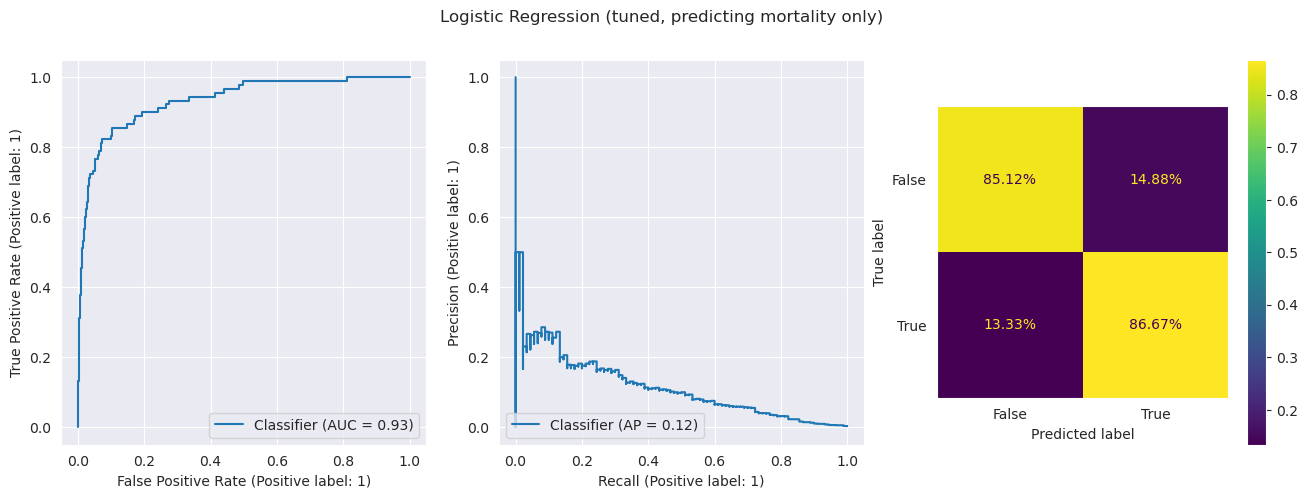

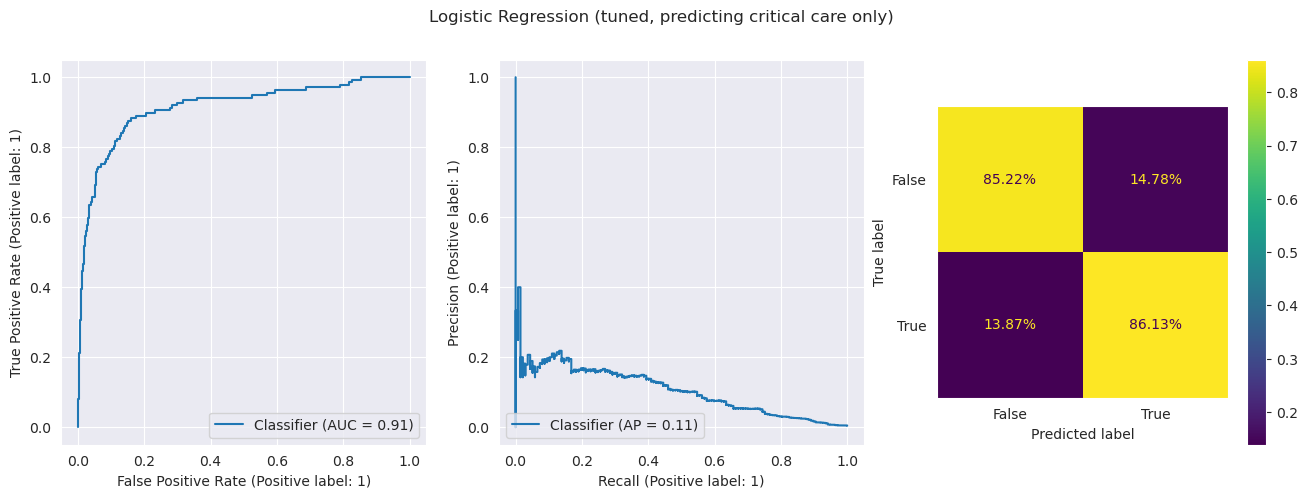

In [20]:
print("Mortality")
Notebook.MORTALITY_RESULTS[modelkey] = evaluate_from_pred(
    y_test_mortality,
    y_pred,
    y_pred_proba,
    plot_title="Logistic Regression (tuned, predicting mortality only)",
    save=f"{Notebook.IMAGE_DIR}/eval_mortality_thresholded_logistic_regression.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)

print("Critical Care")
Notebook.CRITICALCARE_RESULTS[modelkey] = evaluate_from_pred(
    y_test_criticalcare,
    y_pred,
    y_pred_proba,
    plot_title="Logistic Regression (tuned, predicting critical care only)",
    save=f"{Notebook.IMAGE_DIR}/eval_criticalcare_thresholded_logistic_regression.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

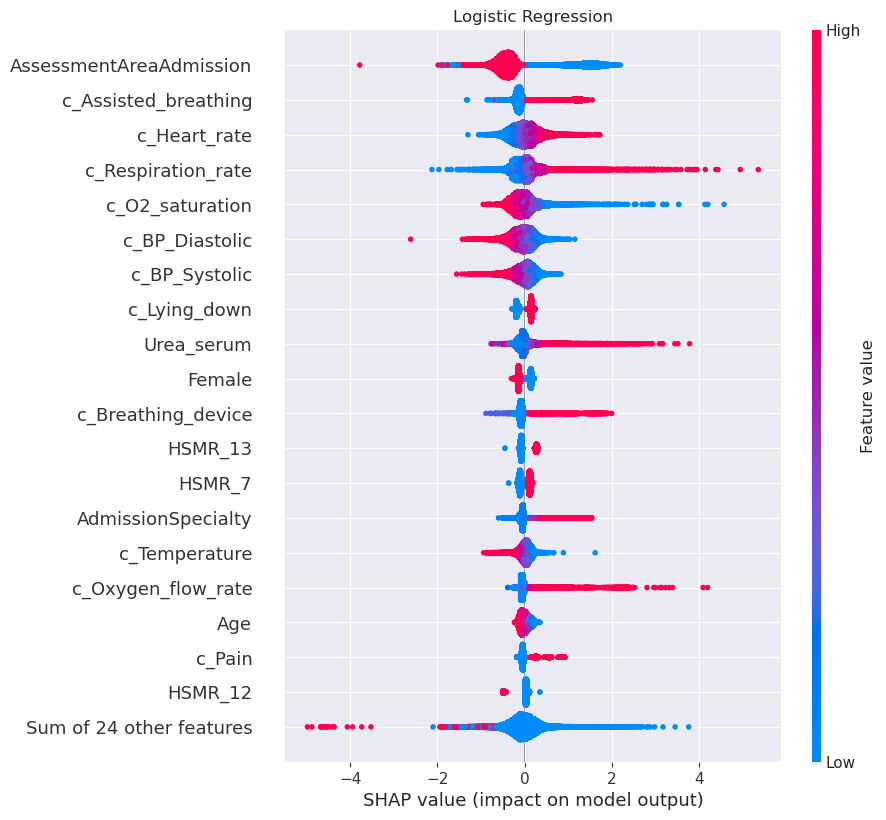

In [21]:
explainer = shap.LinearExplainer(
    model["LR"], X_train, feature_perturbation="correlation_dependent"
)
shap_values = explainer(X_test)
Notebook.EXPLAINERS[modelkey] = (explainer, shap_values)

fig = shap.plots.beeswarm(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("Logistic Regression")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_swarm_logistic_regression.png", bbox_inches="tight"
    )


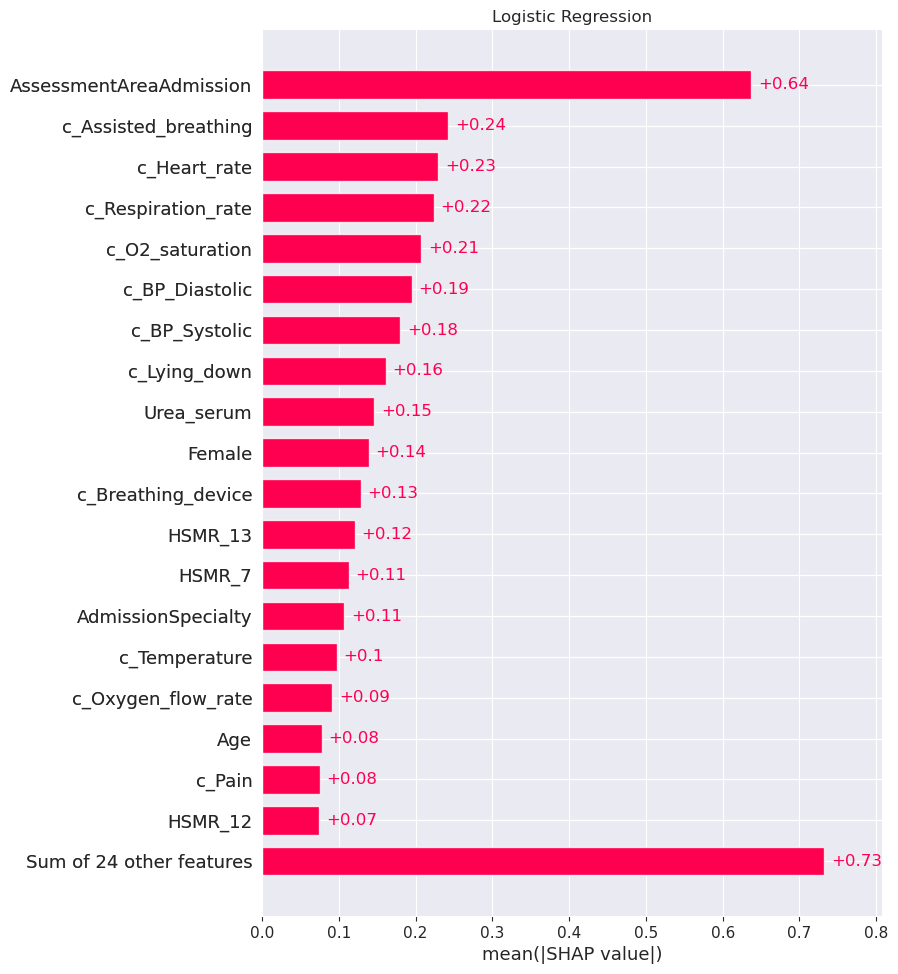

In [22]:
fig = shap.plots.bar(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("Logistic Regression")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_bar_logistic_regression.png", bbox_inches="tight"
    )


### Random Forest

In [23]:
rf_params = {
    "RF__n_estimators": 250,
    "RF__max_features": 0.56,
    "RF__min_samples_split": 8,
    "RF__min_samples_leaf": 3,
    "RF__max_samples": 0.75,
    "RF__class_weight": "balanced",
    "IMB__sampling_strategy": 0.14,
}

if Notebook.RUN_HYPERPARAMETERS:
    rf_params.update(
        tune_randomforest(
            X_train,
            y_train,
            timeout=Notebook.HYPERPARAMETER_TIMEOUT,
            n_jobs=Notebook.HYPERPARAMETER_NJOBS,
        )
    )



BEST PARAMETERS
{'RF__n_estimators': 225, 'RF__max_features': 0.4384582461516513, 'RF__min_samples_split': 8, 'RF__min_samples_leaf': 5, 'RF__max_samples': 0.9563773221335846, 'RF__class_weight': 'balanced_subsample', 'IMB__sampling_strategy': 0.13035107849410627}


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.959517    0.11618  0.751152  0.201235  0.358873  0.946424   

            AUC_CI  
Model  0.930-0.961

array([[30507,  1240],
       [   54,   163]])

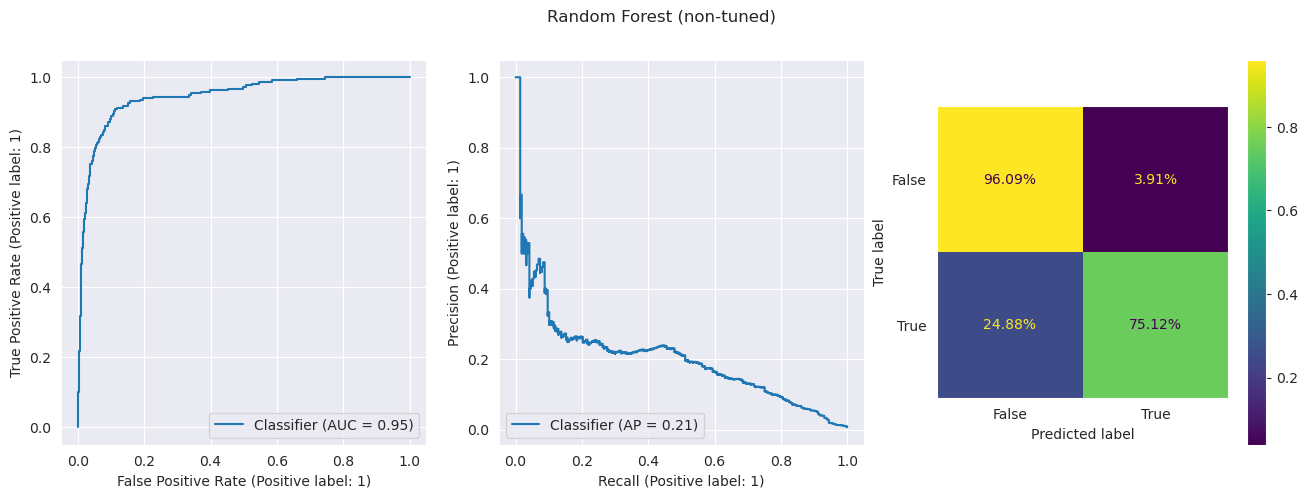

In [24]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

modelkey = "Random Forest"
model = (
    ImbPipeline(steps=[("IMB", RandomUnderSampler()), ("RF", RandomForestClassifier())])
    .set_params(**rf_params)
    .fit(X_train.to_numpy(), y_train)
)

Notebook.MODELS[modelkey] = model

Notebook.EVAL_RESULTS[modelkey] = evaluate(
    model,
    X_test.to_numpy(),
    y_test,
    plot_title="Random Forest (non-tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_random_forest.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)



Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.929076   0.075041  0.834101  0.137695  0.275915  0.946424   

            AUC_CI  
Model  0.930-0.961

array([[29516,  2231],
       [   36,   181]])

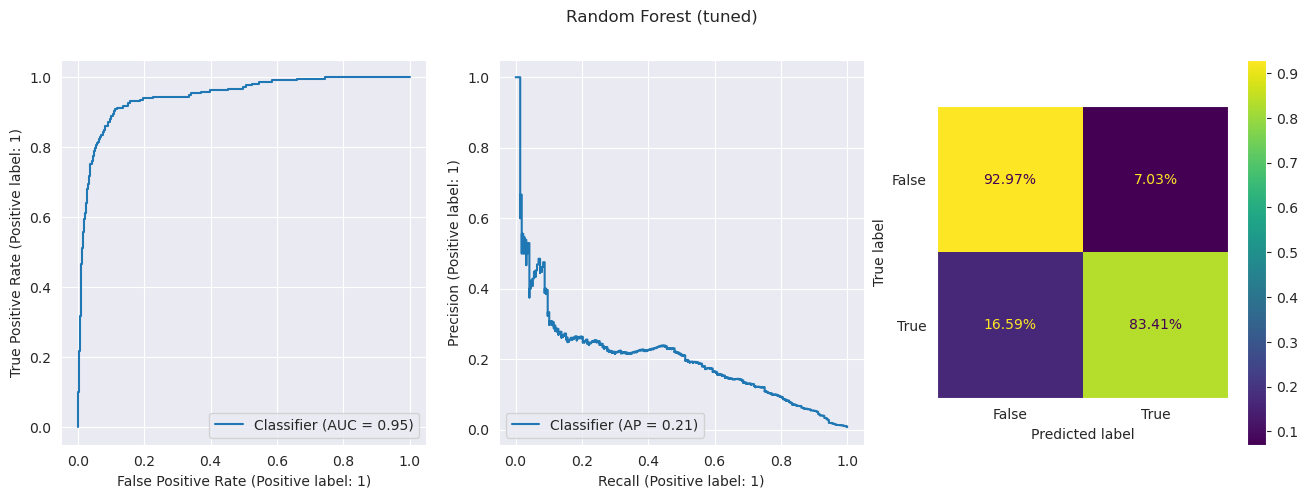

In [25]:
threshold = get_threshold(y_train, model.predict_proba(X_train.to_numpy())[:, 1],)

# Create predictions on the test set, using this new threshold
y_pred_proba = model.predict_proba(X_test.to_numpy())[:, 1]
y_pred = np.where(y_pred_proba > 1 - threshold, 1, 0)

# Produce scores
Notebook.TUNED_RESULTS[modelkey] = evaluate_from_pred(
    y_test,
    y_pred,
    y_pred_proba,
    plot_title="Random Forest (tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_thresholded_random_forest.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


Mortality


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.926167   0.029436  0.788889  0.056755  0.128066  0.935643   

            AUC_CI  
Model  0.905-0.961

array([[29533,  2341],
       [   19,    71]])

Critical Care


Accuracy  Precision    Recall  F1 Score  F2 Score      AUC       AUC_CI
Model  0.927637   0.048922  0.861314  0.092585  0.199324  0.95339  0.936-0.969

array([[29533,  2294],
       [   19,   118]])

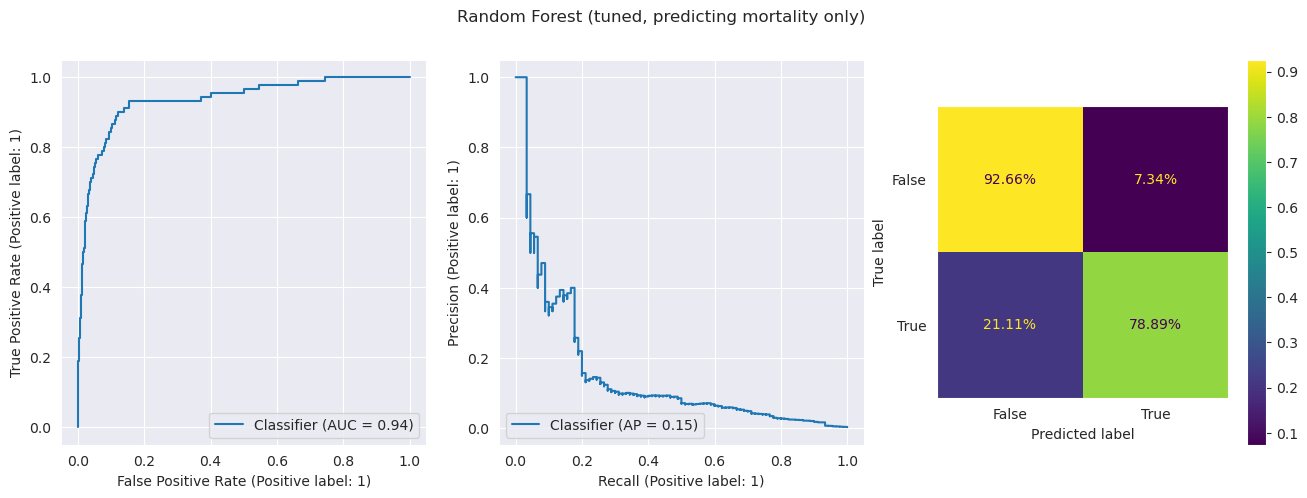

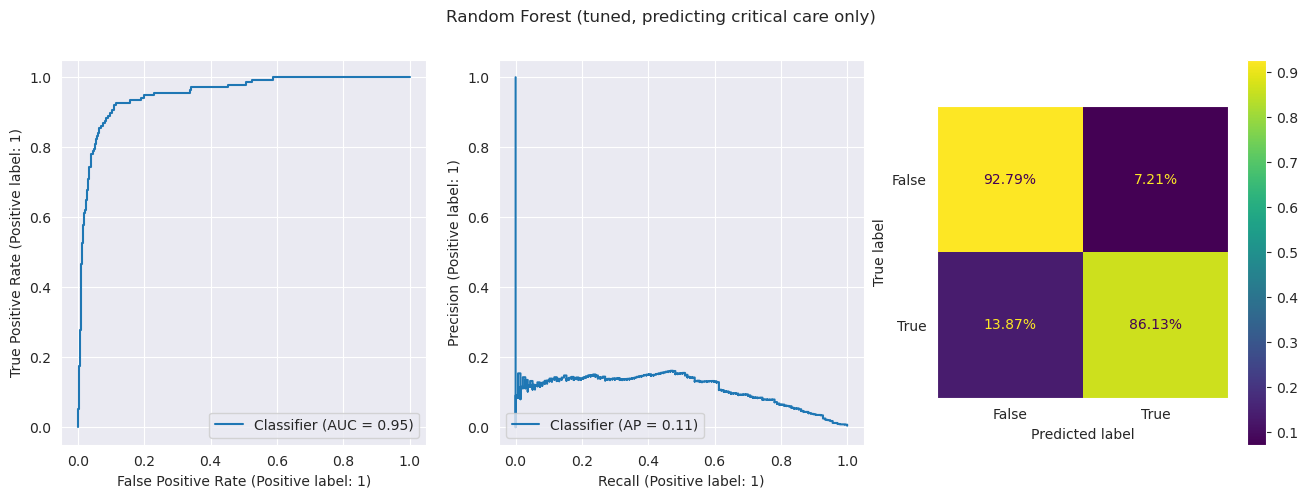

In [26]:
print("Mortality")
Notebook.MORTALITY_RESULTS[modelkey] = evaluate_from_pred(
    y_test_mortality,
    y_pred,
    y_pred_proba,
    plot_title="Random Forest (tuned, predicting mortality only)",
    save=f"{Notebook.IMAGE_DIR}/eval_mortality_thresholded_random_forest.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)

print("Critical Care")
Notebook.CRITICALCARE_RESULTS[modelkey] = evaluate_from_pred(
    y_test_criticalcare,
    y_pred,
    y_pred_proba,
    plot_title="Random Forest (tuned, predicting critical care only)",
    save=f"{Notebook.IMAGE_DIR}/eval_criticalcare_thresholded_random_forest.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


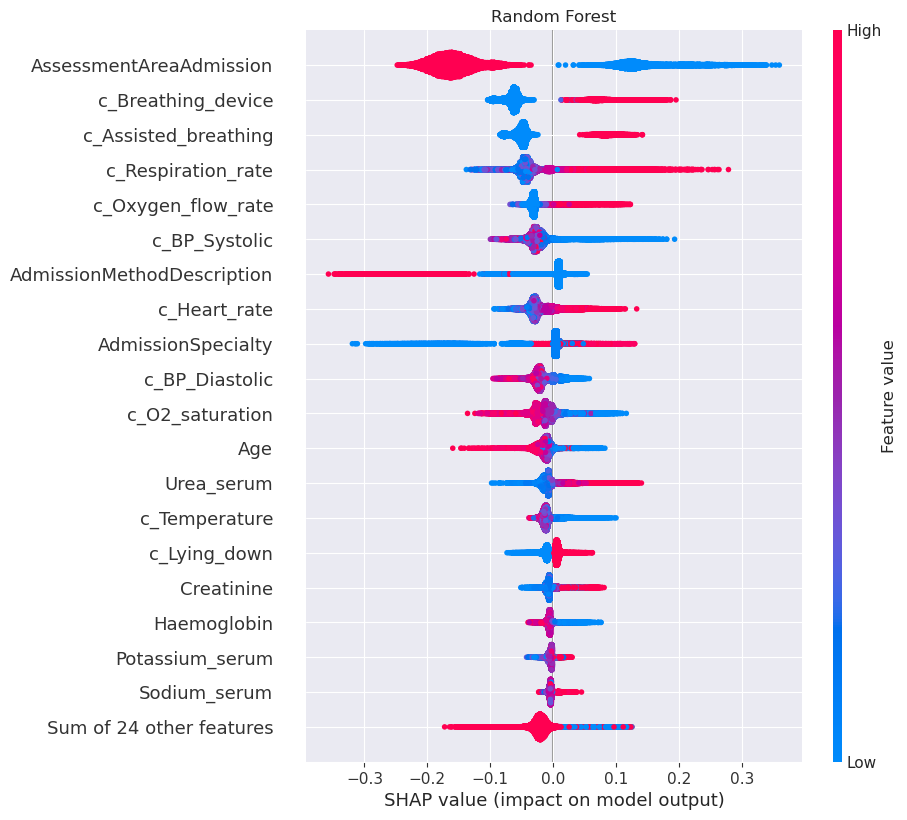

In [27]:
explainer = shap.TreeExplainer(model["RF"])
shap_values = explainer(X_test)
Notebook.EXPLAINERS[modelkey] = (explainer, shap_values)

fig = shap.plots.beeswarm(
    shap_values[:, :, 1], max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("Random Forest")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_swarm_random_forest.png", bbox_inches="tight"
    )


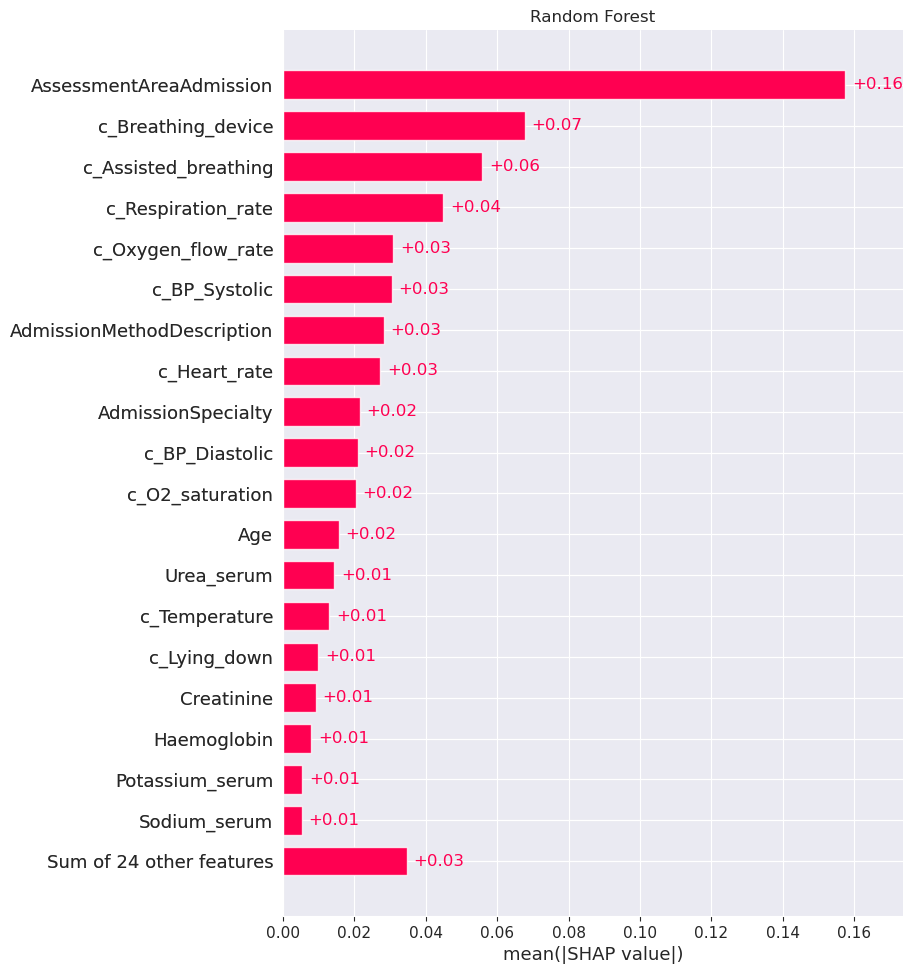

In [28]:
fig = shap.plots.bar(
    shap_values[:, :, 1], max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("Random Forest")

if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/shap_bar_random_forest.png", bbox_inches="tight")


### XGBoost

In [29]:
xgboost_params = {
    "XGB__verbosity": 0,
    "XGB__n_jobs": 1,
    "XGB__missing": -1,
    "XGB__objective": "binary:logistic",
    "XGB__enable_categorical": True,
    "XGB__tree_method": "hist",
    "XGB__missing": -1,
    "XGB__booster": "gbtree",
    "XGB__lambda": 7e-2,
    "XGB__alpha": 7e-05,
    "XGB__subsample": 0.42,
    "XGB__colsample_bytree": 0.87,
    "XGB__scale_pos_weight": 14,
    "XGB__max_depth": 7,
    "XGB__min_child_weight": 10,
    "XGB__eta": 0.034,
    "XGB__gamma": 4e-08,
    "XGB__grow_policy": "lossguide",
    "IMB__sampling_strategy": 0.1,
}


if Notebook.RUN_HYPERPARAMETERS:
    xgboost_params.update(
        tune_xgboost(
            X_train_lgbm,
            y_train_lgbm,
            timeout=Notebook.HYPERPARAMETER_TIMEOUT,
            n_jobs=Notebook.HYPERPARAMETER_NJOBS,
        )
    )



BEST PARAMETERS
{'XGB__tree_method': 'hist', 'XGB__lambda': 0.03324238661951266, 'XGB__alpha': 2.047733783639252e-08, 'XGB__subsample': 0.5889515899729888, 'XGB__colsample_bytree': 0.9085010755195111, 'XGB__scale_pos_weight': 53, 'IMB__sampling_strategy': 0.29929675768207403, 'XGB__max_depth': 9, 'XGB__min_child_weight': 10, 'XGB__eta': 0.05291750063505839, 'XGB__gamma': 4.5811253659695633e-08, 'XGB__grow_policy': 'depthwise'}


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.813102   0.032635  0.926267  0.063049   0.14302  0.938709   

            AUC_CI  
Model  0.918-0.957

array([[25789,  5958],
       [   16,   201]])

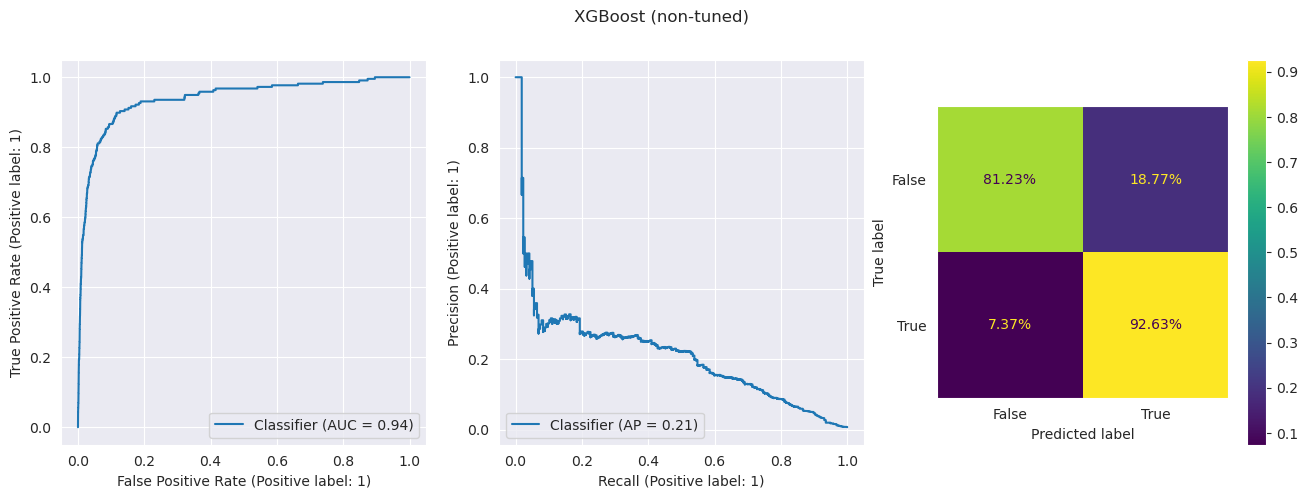

In [30]:
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

modelkey = "XGBoost"
model = (
    ImbPipeline(steps=[("IMB", RandomUnderSampler()), ("XGB", XGBClassifier()),])
    .set_params(**xgboost_params)
    .fit(X_train_lgbm, y_train_lgbm)
)

Notebook.MODELS[modelkey] = model

Notebook.EVAL_RESULTS[modelkey] = evaluate(
    model,
    X_test_lgbm,
    y_test_lgbm,
    "XGBoost (non-tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_xgboost.png" if Notebook.SAVE_IMAGES else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.301308   0.009449  0.981567  0.018718  0.045493  0.938709   

            AUC_CI  
Model  0.918-0.957

array([[ 9418, 22329],
       [    4,   213]])

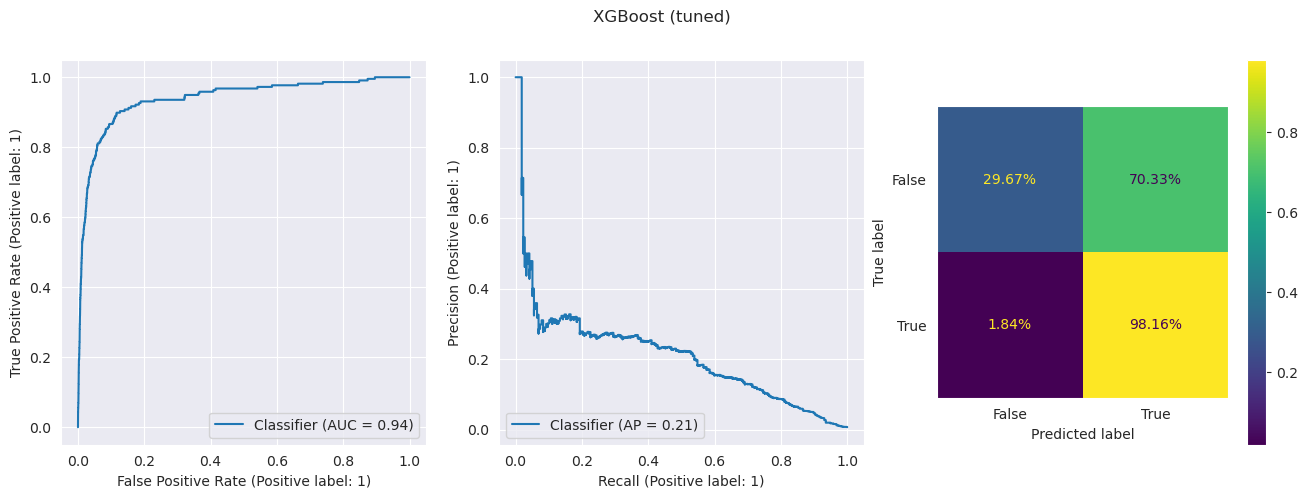

In [31]:
threshold = get_threshold(y_train_lgbm, model.predict_proba(X_train_lgbm)[:, 1],)

# Create predictions on the test set, using this new threshold
y_pred_proba = model.predict_proba(X_test_lgbm)[:, 1]
y_pred = np.where(y_pred_proba > 1 - threshold, 1, 0)

# Produce scores
Notebook.TUNED_RESULTS[modelkey] = evaluate_from_pred(
    y_test_lgbm,
    y_pred,
    y_pred_proba,
    plot_title="XGBoost (tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_thresholded_xgboost.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


Mortality


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.297522   0.003948  0.988889  0.007865  0.019431  0.944197   

            AUC_CI  
Model  0.916-0.965

array([[ 9421, 22453],
       [    1,    89]])

Critical Care


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.298867   0.005944  0.978102  0.011817  0.029017  0.935541   

            AUC_CI  
Model  0.908-0.960

array([[ 9419, 22408],
       [    3,   134]])

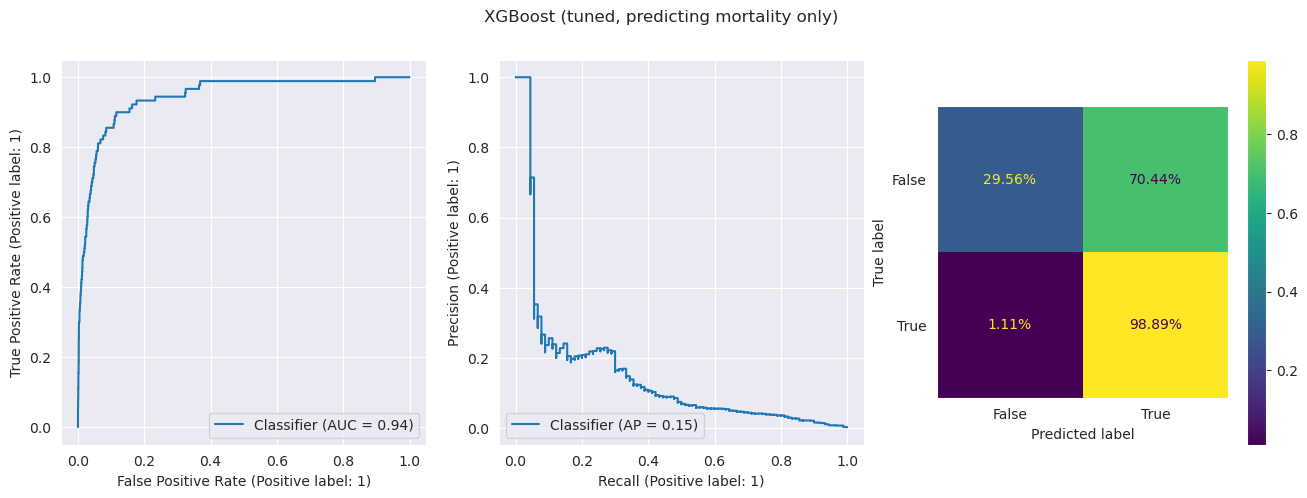

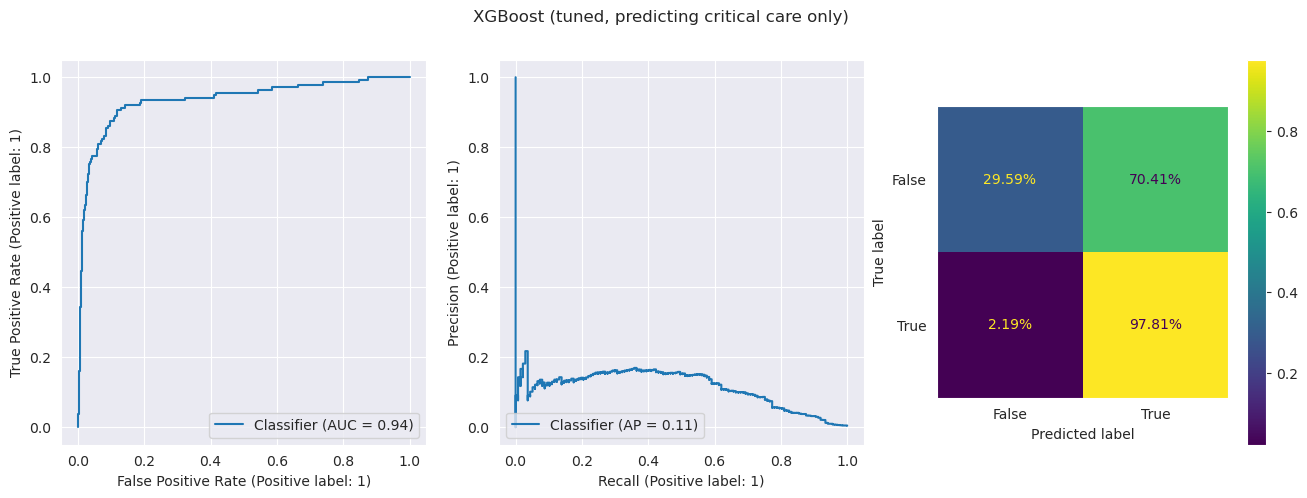

In [32]:
print("Mortality")
Notebook.MORTALITY_RESULTS[modelkey] = evaluate_from_pred(
    y_test_mortality,
    y_pred,
    y_pred_proba,
    plot_title="XGBoost (tuned, predicting mortality only)",
    save=f"{Notebook.IMAGE_DIR}/eval_mortality_thresholded_xgboost.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)

print("Critical Care")
Notebook.CRITICALCARE_RESULTS[modelkey] = evaluate_from_pred(
    y_test_criticalcare,
    y_pred,
    y_pred_proba,
    plot_title="XGBoost (tuned, predicting critical care only)",
    save=f"{Notebook.IMAGE_DIR}/eval_criticalcare_thresholded_xgboost.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


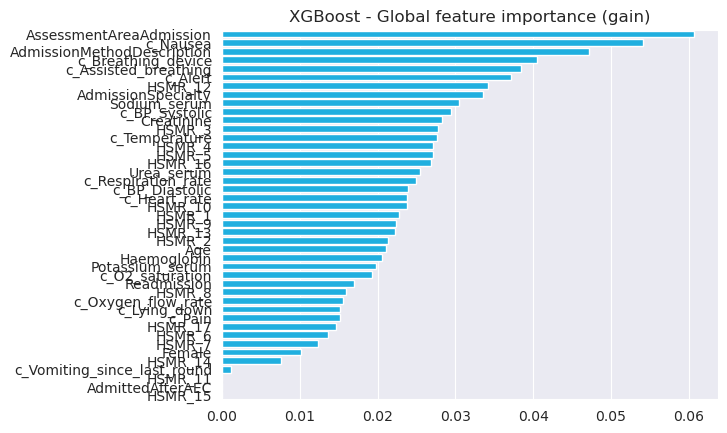

In [33]:
sorted_idx = model["XGB"].feature_importances_.argsort()[::-1]
fig = sns.barplot(
    x=model["XGB"].feature_importances_[sorted_idx],
    y=X_train.columns[sorted_idx],
    color="deepskyblue",
)
fig.set_title("XGBoost - Global feature importance (gain)")

if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/global_weights_xgboost.png", bbox_inches="tight")



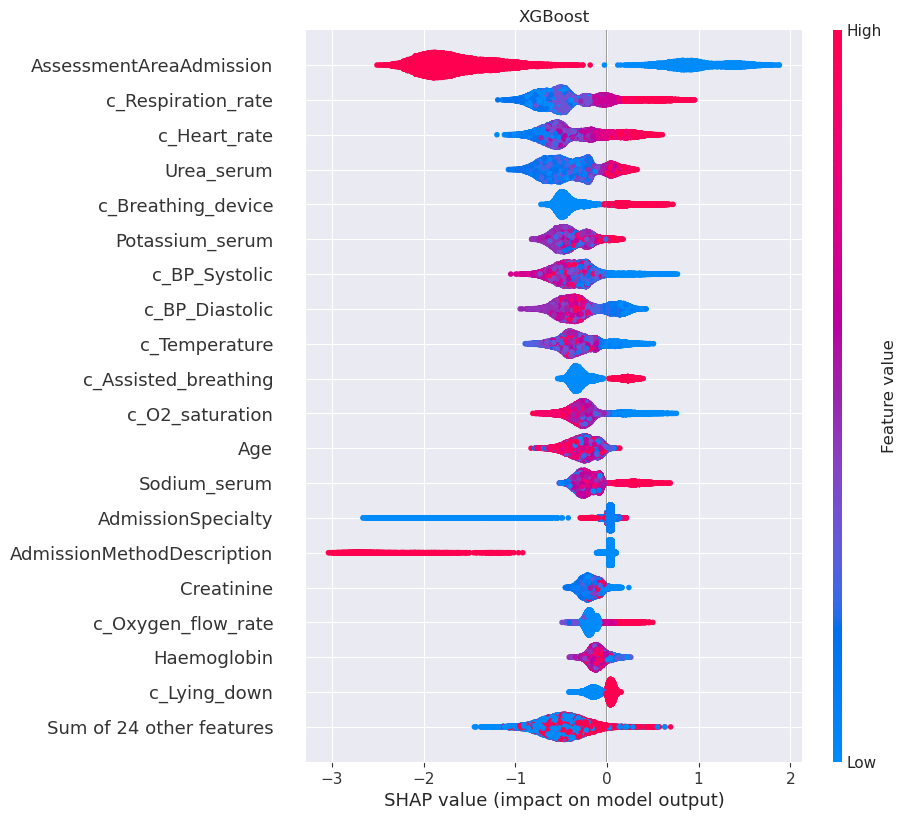

In [34]:
explainer = shap.TreeExplainer(model["XGB"])
shap_values = explainer(X_test)
Notebook.EXPLAINERS[modelkey] = (explainer, shap_values)

fig = shap.plots.beeswarm(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("XGBoost")

if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/shap_swarm_xgboost.png", bbox_inches="tight")


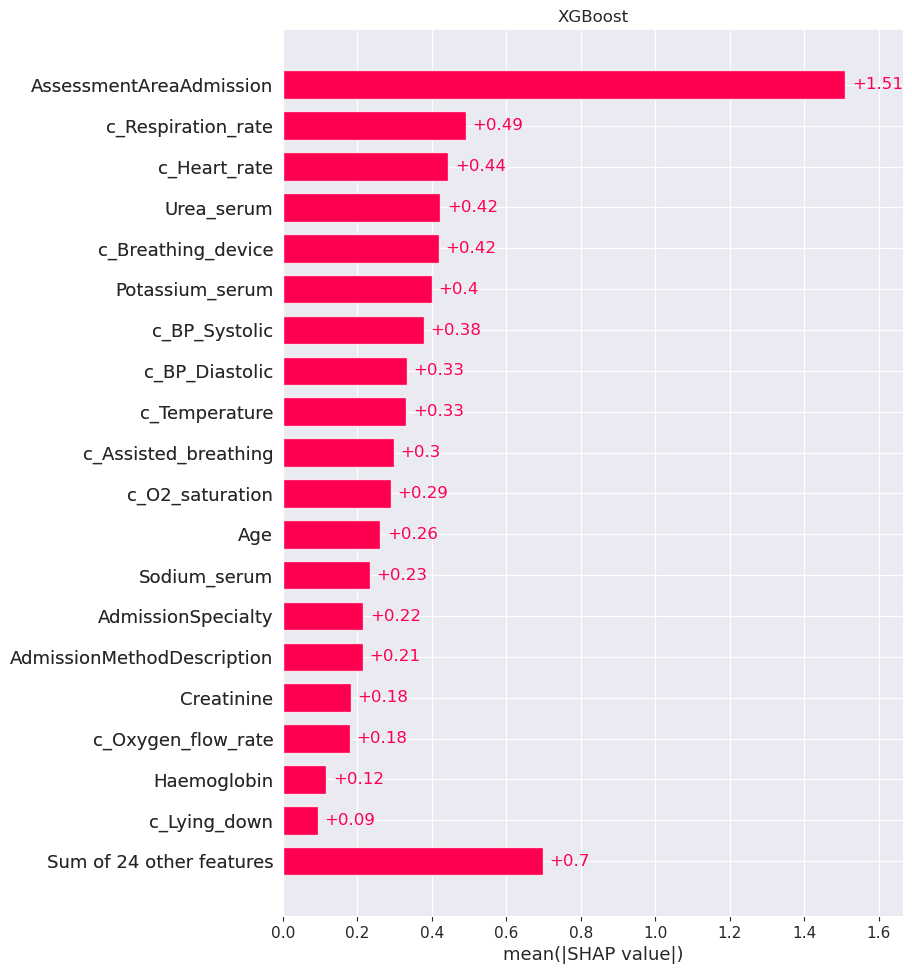

In [35]:
fig = shap.plots.bar(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("XGBoost")

if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/shap_bar_xgboost.png", bbox_inches="tight")


### LightGBM

In [36]:
lgbm_params = {
    "LGBM__objective": "binary",
    "LGBM__metrics": ["l2", "auc"],
    "LGBM__boosting_type": "gbdt",
    "LGBM__is_unbalance": True,
    "LGBM__n_jobs": 1,
    "LGBM__feature_pre_filter": False,
    "LGBM__lambda_l1": 0.15,
    "LGBM__lambda_l2": 3.2,
    "LGBM__num_leaves": 225,
    "LGBM__feature_fraction": 0.8,
    "LGBM__bagging_fraction": 0.8,
    "LGBM__bagging_freq": 7,
    "LGBM__min_child_samples": 45,
    "IMB__sampling_strategy": 0.1,
}

if Notebook.RUN_HYPERPARAMETERS:
    lgbm_params.update(
        tune_lgbm(
            X_train_lgbm,
            y_train_lgbm,
            categorical_cols_idx,
            timeout=Notebook.HYPERPARAMETER_TIMEOUT,
            n_jobs=Notebook.HYPERPARAMETER_NJOBS,
        )
    )


[LightGBM] [Warning] feature_fraction is set=0.9231604065103874, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9231604065103874
[LightGBM] [Warning] lambda_l1 is set=1.094680279153517e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.094680279153517e-06
[LightGBM] [Warning] bagging_fraction is set=0.80035320918681, subsample=1.0 will be ignored. Current value: bagging_fraction=0.80035320918681
[LightGBM] [Warning] lambda_l2 is set=1.287017186513256e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.287017186513256e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.722798501784518, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.722798501784518
[LightGBM] [Warning] lambda_l1 is set=4.010120496571635e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.010120496571635e-08
[LightGBM] [Warning] bagg

[LightGBM] [Warning] feature_fraction is set=0.8924154899224015, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8924154899224015
[LightGBM] [Warning] lambda_l1 is set=9.582756745607862, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.582756745607862
[LightGBM] [Warning] bagging_fraction is set=0.9565073439638455, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9565073439638455
[LightGBM] [Warning] lambda_l2 is set=0.0001259714284160393, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001259714284160393
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Accuracy  Precision    Recall  F1 Score  F2 Score      AUC       AUC_CI
Model  0.933675   0.081022  0.847926   0.14791  0.293087  0.94561  0.927-0.962

array([[29660,  2087],
       [   33,   184]])

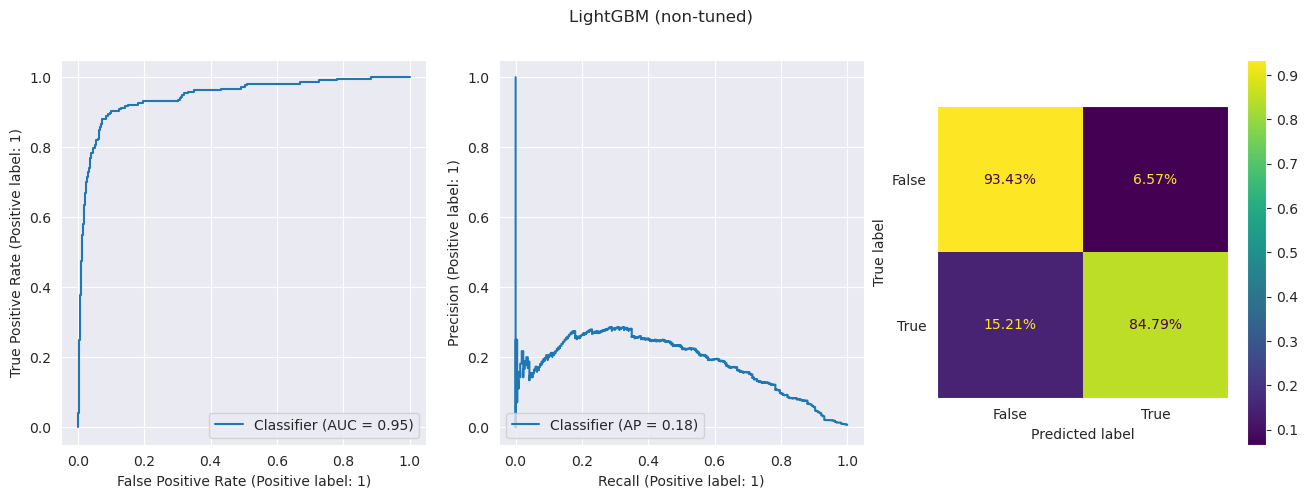

In [37]:
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

modelkey = "LightGBM"

model = (
    ImbPipeline(steps=[("IMB", RandomUnderSampler()), ("LGBM", LGBMClassifier()),])
    .set_params(**lgbm_params)
    .fit(
        X_train_lgbm,
        y_train_lgbm,
        LGBM__categorical_feature=categorical_cols_idx,
        LGBM__feature_name=list(X_train.columns),
    )
)

Notebook.MODELS[modelkey] = model

Notebook.EVAL_RESULTS[modelkey] = evaluate(
    model,
    X_test_lgbm,
    y_test_lgbm,
    plot_title="LightGBM (non-tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_lightgbm.png" if Notebook.SAVE_IMAGES else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


Accuracy  Precision    Recall  F1 Score  F2 Score      AUC       AUC_CI
Model  0.932518   0.079723  0.847926  0.145743  0.289673  0.94561  0.927-0.962

array([[29623,  2124],
       [   33,   184]])

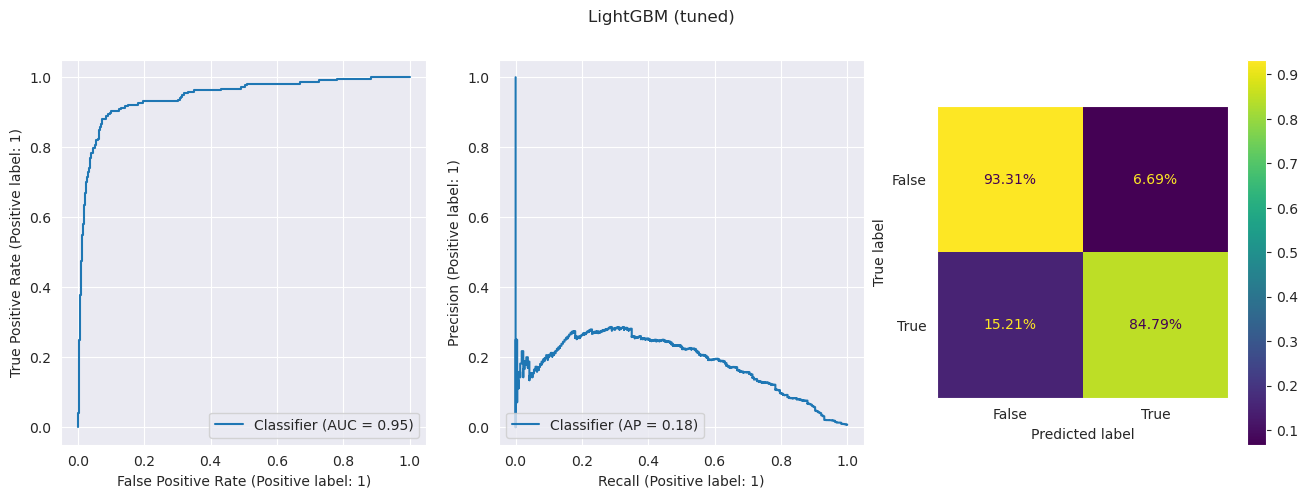

In [38]:
threshold = get_threshold(y_test_lgbm, model.predict_proba(X_test_lgbm)[:, 1],)

# Create predictions on the test set, using this new threshold
y_pred_proba = model.predict_proba(X_test_lgbm)[:, 1]
y_pred = np.where(y_pred_proba > threshold, 1, 0)

Notebook.TUNED_RESULTS[modelkey] = evaluate_from_pred(
    y_test_lgbm,
    y_pred,
    y_pred_proba,
    plot_title="LightGBM (tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_thresholded_lightgbm.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


Mortality


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.929921   0.034229  0.877778  0.065888  0.148051  0.948336   

            AUC_CI  
Model  0.921-0.970

array([[29645,  2229],
       [   11,    79]])

Critical Care


Accuracy  Precision    Recall  F1 Score  F2 Score      AUC       AUC_CI
Model  0.930703   0.049827  0.839416   0.09407  0.201331  0.94451  0.920-0.965

array([[29634,  2193],
       [   22,   115]])

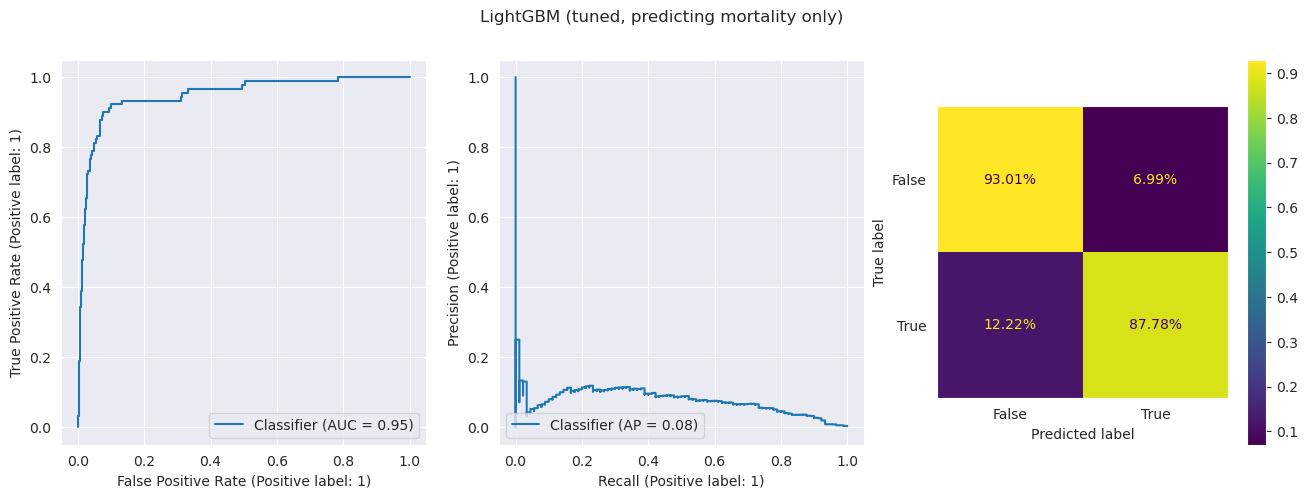

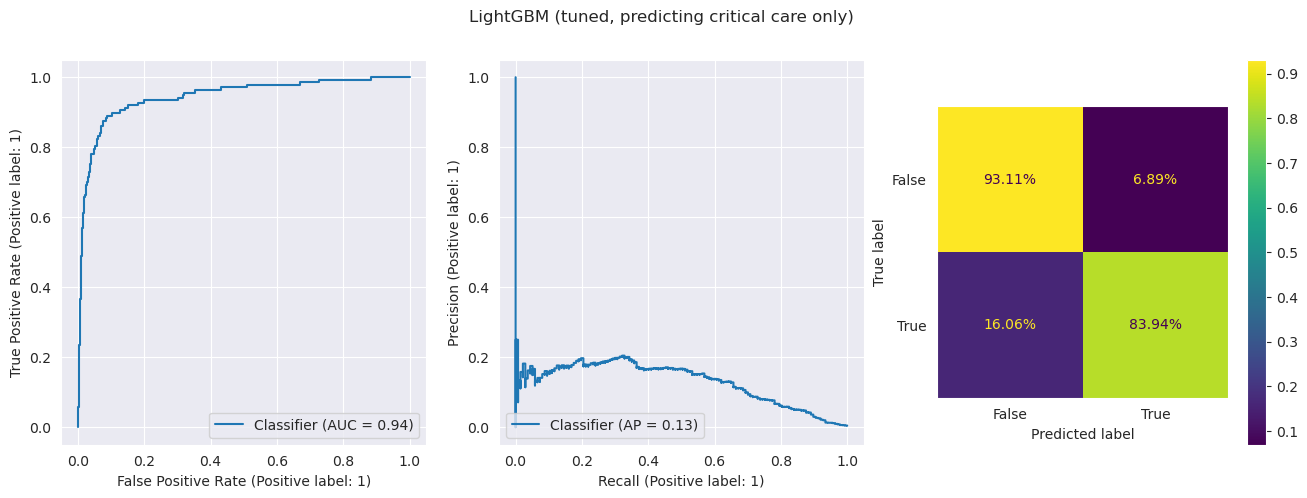

In [39]:
print("Mortality")
Notebook.MORTALITY_RESULTS[modelkey] = evaluate_from_pred(
    y_test_mortality,
    y_pred,
    y_pred_proba,
    plot_title="LightGBM (tuned, predicting mortality only)",
    save=f"{Notebook.IMAGE_DIR}/eval_mortality_thresholded_lightgbm.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)

print("Critical Care")
Notebook.CRITICALCARE_RESULTS[modelkey] = evaluate_from_pred(
    y_test_criticalcare,
    y_pred,
    y_pred_proba,
    plot_title="LightGBM (tuned, predicting critical care only)",
    save=f"{Notebook.IMAGE_DIR}/eval_criticalcare_thresholded_lightgbm.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


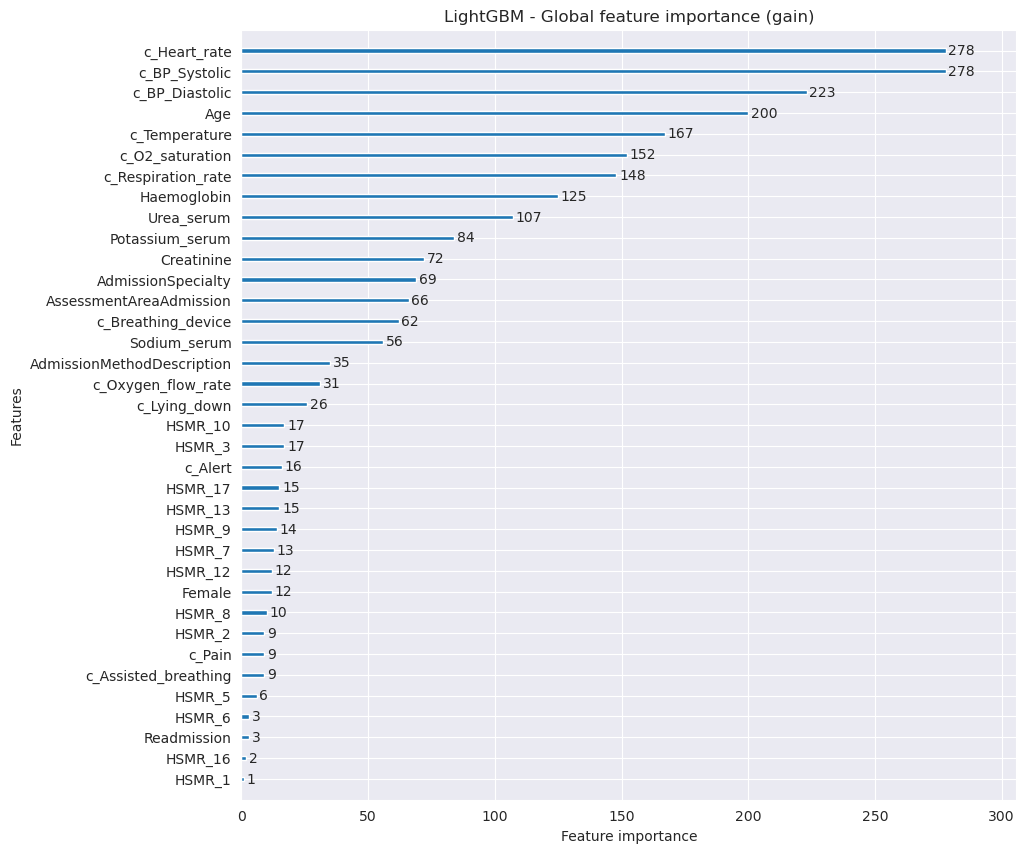

In [40]:
import lightgbm as lgb

fig = lgb.plot_importance(model["LGBM"], figsize=(10, 10))
fig.set_title("LightGBM - Global feature importance (gain)")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/global_weights_lightgbm.png", bbox_inches="tight"
    )


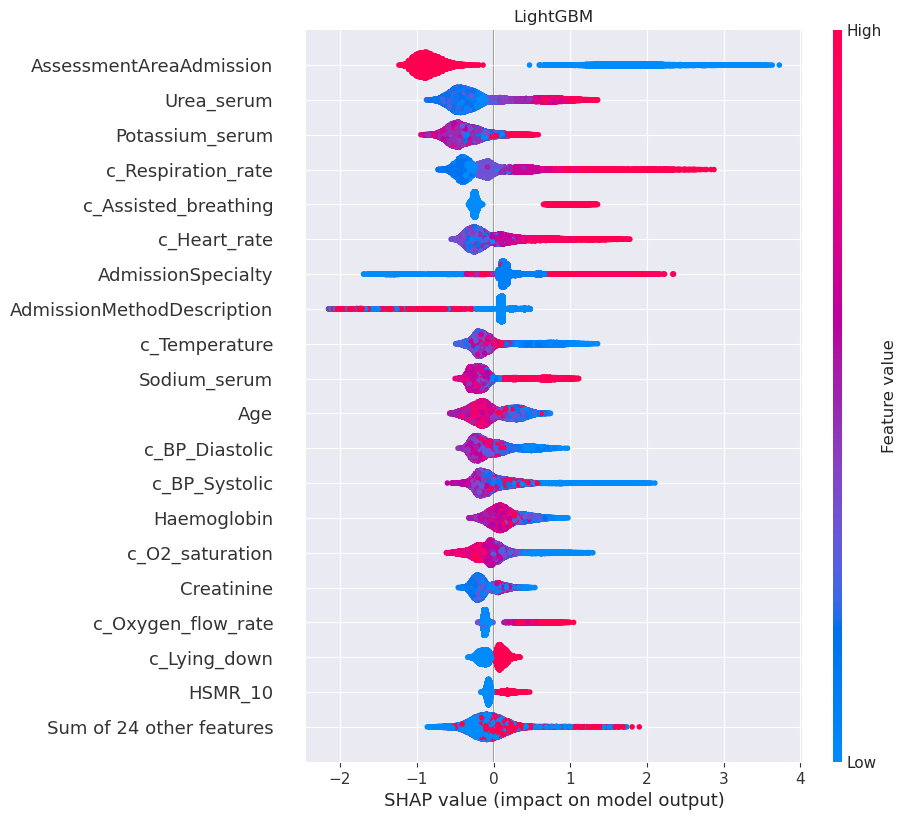

In [41]:
explainer = shap.TreeExplainer(model["LGBM"])
shap_values = explainer(X_test)
Notebook.EXPLAINERS[modelkey] = (explainer, shap_values)

fig = shap.plots.beeswarm(
    shap_values[:, :, 1], max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("LightGBM")
if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/shap_swarm_lightgbm.png", bbox_inches="tight")


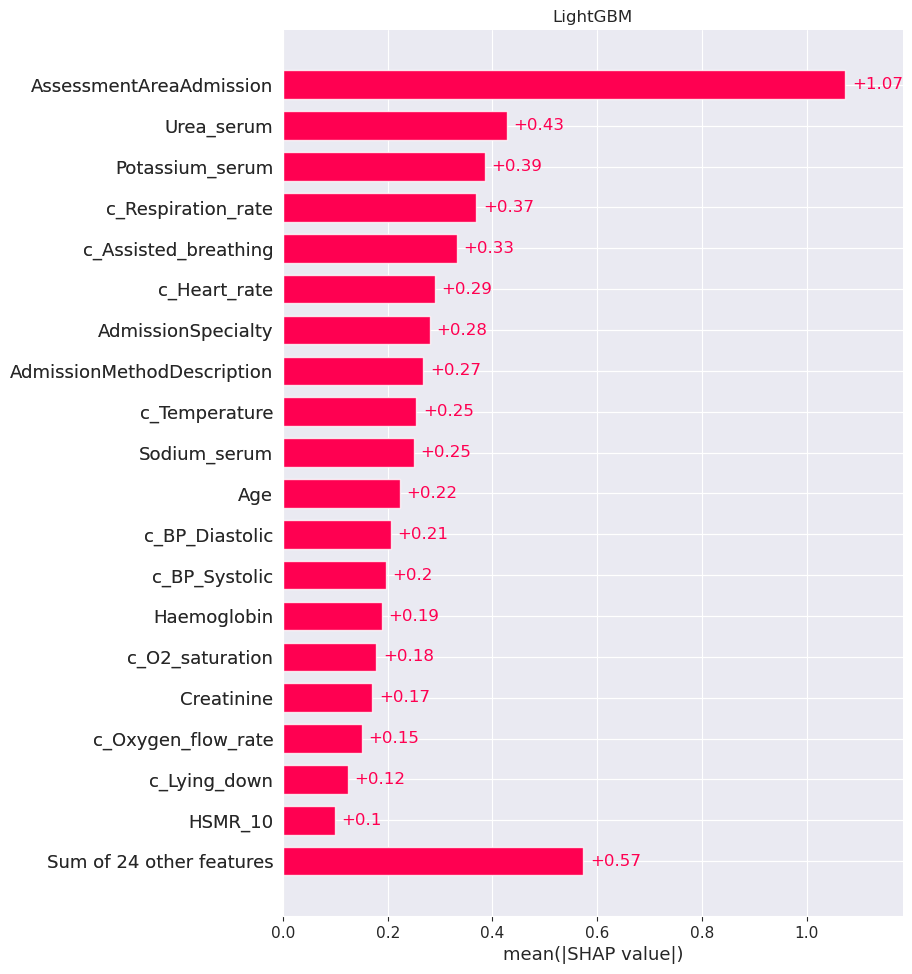

In [42]:
fig = shap.plots.bar(
    shap_values[:, :, 1], max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("LightGBM")

if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/shap_bar_lightgbm.png", bbox_inches="tight")


### Isolation Forest

In [43]:
if_params = {
    "n_estimators": 140,
    "max_samples": 0.465,
    "contamination": 0.0213,
    "max_features": 0.69,
    "bootstrap": False,
}

if Notebook.RUN_HYPERPARAMETERS:
    if_params = tune_isolationforest(
        X_train_if,
        y_train_if,
        timeout=Notebook.HYPERPARAMETER_TIMEOUT,
        n_jobs=Notebook.HYPERPARAMETER_NJOBS,
    )



BEST PARAMETERS
{'n_estimators': 187, 'max_samples': 0.32873349416183884, 'contamination': 0.05342591191605385, 'max_features': 0.9427189465937019, 'bootstrap': True}


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model   0.92623    0.04774  0.520737  0.087461  0.174652  0.864062   

            AUC_CI  
Model  0.838-0.888

array([[29493,  2254],
       [  104,   113]])

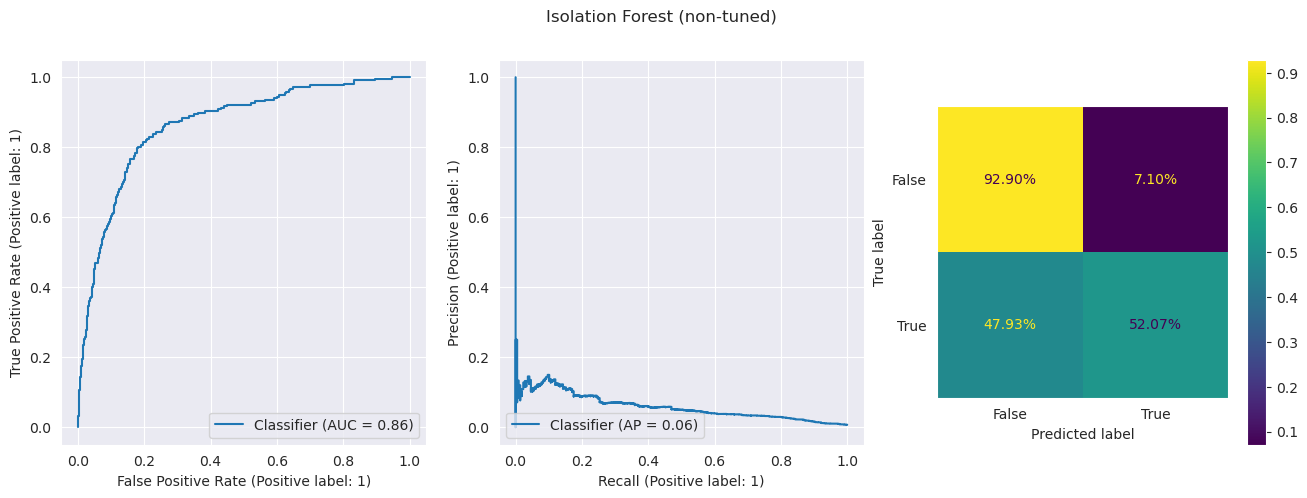

In [44]:
modelkey = "Isolation Forest"

model = IsolationForestWrapper(**if_params).fit(X_train_if[~y_train_if].to_numpy())
Notebook.MODELS[modelkey] = model

Notebook.EVAL_RESULTS[modelkey] = evaluate(
    model,
    X_test_if.to_numpy(),
    y_test_if,
    plot_title="Isolation Forest (non-tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_isolation_forest.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.598455   0.015065  0.903226  0.029636  0.070615  0.864062   

            AUC_CI  
Model  0.838-0.888

array([[18933, 12814],
       [   21,   196]])

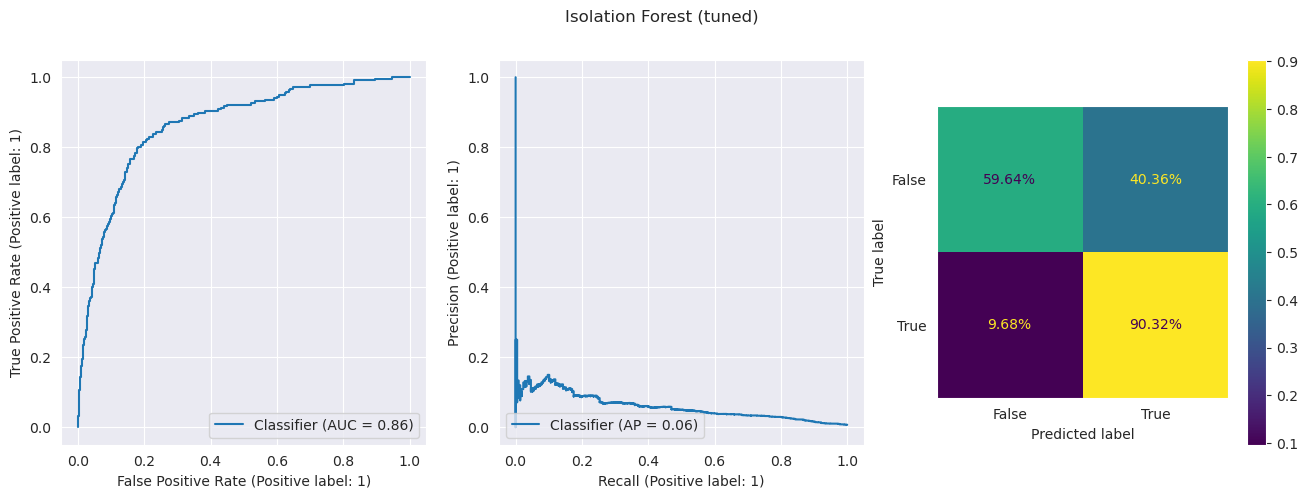

In [45]:
y_pred_proba_train = model.decision_function(X_train_if)
y_pred_proba_train -= y_pred_proba_train.min()

threshold = get_threshold(y_train_if, y_pred_proba_train,)

# Create predictions on the test set, using this new threshold
y_pred_proba = model.decision_function(X_test_if)
y_pred = np.where(y_pred_proba - y_pred_proba.min() > threshold, 1, 0)

Notebook.TUNED_RESULTS[modelkey] = evaluate_from_pred(
    y_test_if,
    y_pred,
    y_pred_proba,
    plot_title="Isolation Forest (tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_thresholded_isolation_forest.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


Mortality


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model   0.59542   0.006457  0.933333  0.012824  0.031414  0.886767   

            AUC_CI  
Model  0.844-0.923

array([[18948, 12926],
       [    6,    84]])

Critical Care


Accuracy  Precision    Recall  F1 Score  F2 Score      AUC       AUC_CI
Model  0.596327   0.009377  0.890511  0.018559  0.044992  0.85316  0.821-0.882

array([[18939, 12888],
       [   15,   122]])

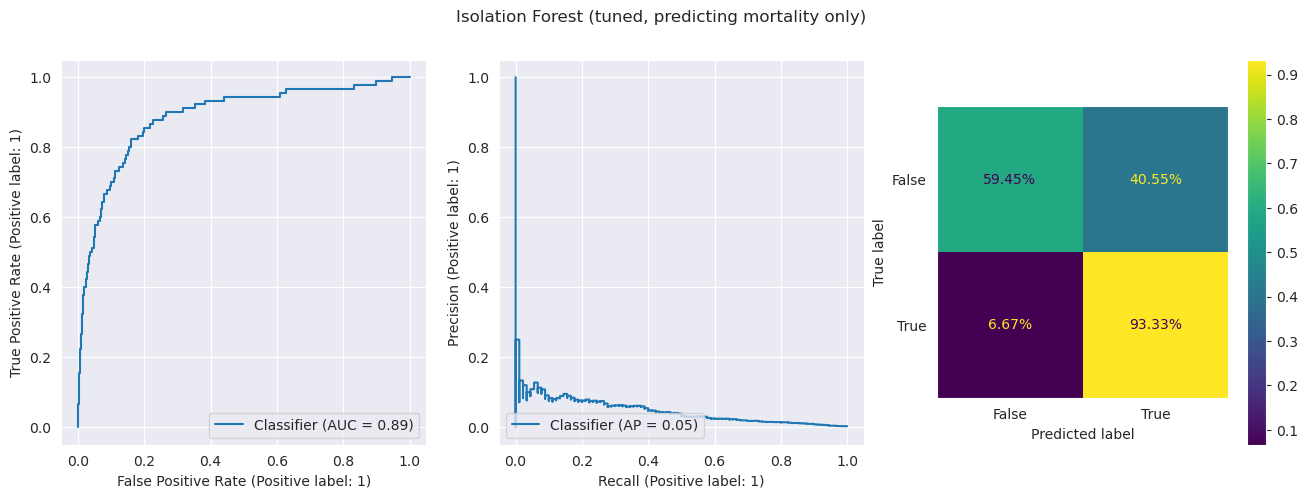

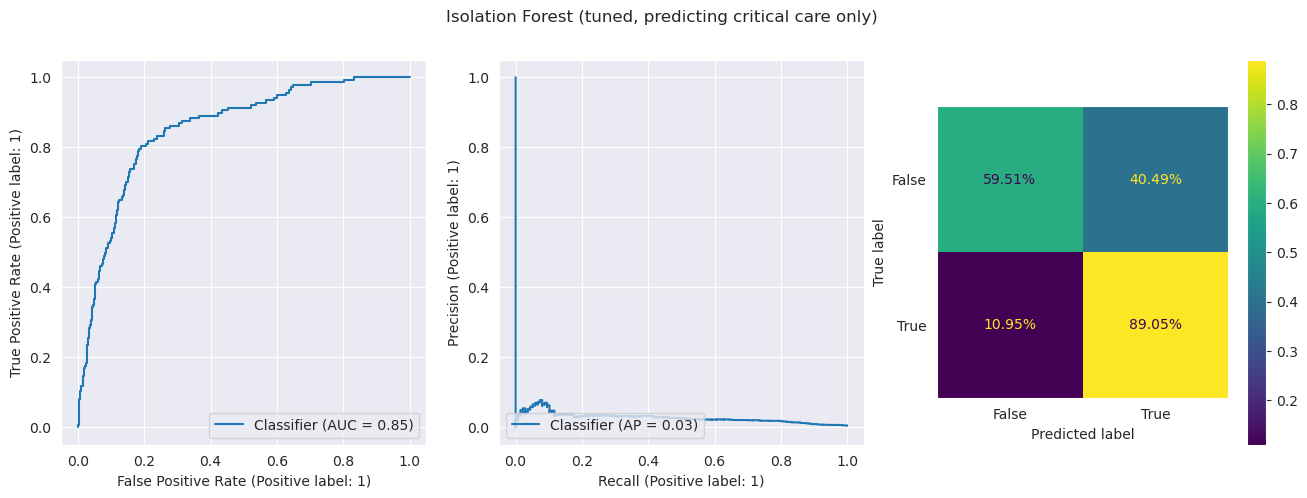

In [46]:
print("Mortality")
Notebook.MORTALITY_RESULTS[modelkey] = evaluate_from_pred(
    y_test_mortality,
    y_pred,
    y_pred_proba,
    plot_title="Isolation Forest (tuned, predicting mortality only)",
    save=f"{Notebook.IMAGE_DIR}/eval_mortality_thresholded_isolation_forest.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)

print("Critical Care")
Notebook.CRITICALCARE_RESULTS[modelkey] = evaluate_from_pred(
    y_test_criticalcare,
    y_pred,
    y_pred_proba,
    plot_title="Isolation Forest (tuned, predicting critical care only)",
    save=f"{Notebook.IMAGE_DIR}/eval_criticalcare_thresholded_isolation_forest.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


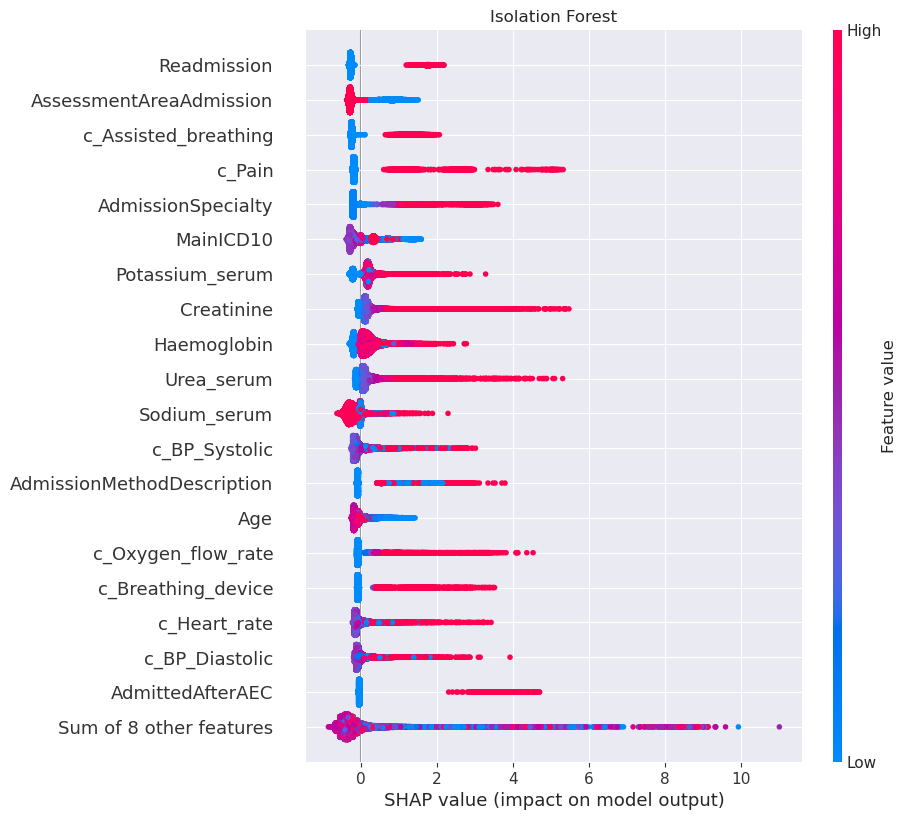

In [47]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test_if)
shap_values.values = -shap_values.values  # Fix for isolation forest's unique labelling
Notebook.EXPLAINERS[modelkey] = (explainer, shap_values)

fig = shap.plots.beeswarm(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("Isolation Forest")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_swarm_isolation_forest.png", bbox_inches="tight"
    )



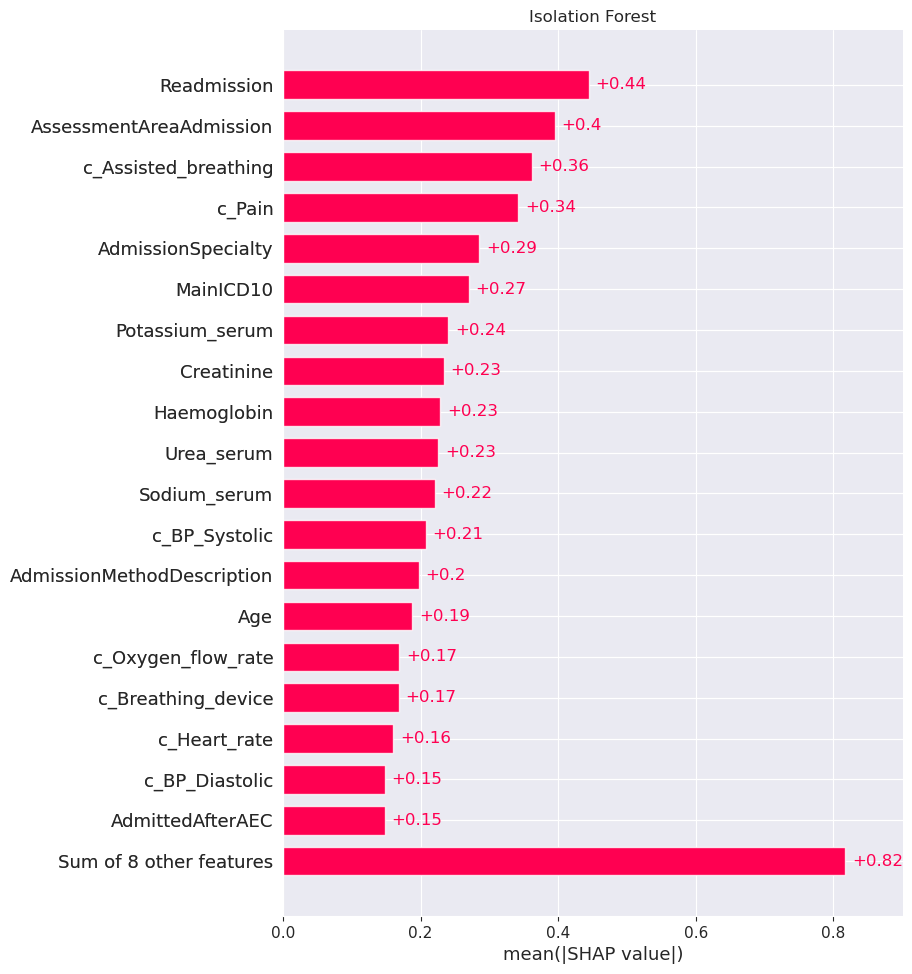

In [48]:
fig = shap.plots.bar(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("Isolation Forest")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_bar_isolation_forest.png", bbox_inches="tight"
    )



### TabNet

In [49]:
import torch
from pytorch_tabnet.tab_model import TabNetClassifier

tabnet_params = dict(
    cat_idxs=categorical_cols_idx,
    cat_dims=categorical_cols_dims,
    n_a=64,
    n_d=64,
    n_steps=3,
    gamma=1.0,
    lambda_sparse=9e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=0.02, weight_decay=1e-05),
    mask_type="sparsemax",
    n_shared=1,
    scheduler_params=dict(mode="min", patience=5, min_lr=1e-05, factor=0.5,),
    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
    verbose=0,
    device_name="cuda" if torch.cuda.is_available() else "cpu",
)

if Notebook.RUN_HYPERPARAMETERS:
    returned_params, tabnet_patience, tabnet_scheduler_patience = tune_tabnet(
        X_train,
        y_train,
        categorical_cols_idx,
        categorical_cols_dims,
        timeout=Notebook.HYPERPARAMETER_TIMEOUT,
        n_jobs=Notebook.HYPERPARAMETER_NJOBS,
    )

    tabnet_params.update(returned_params)
    tabnet_params["scheduler_params"]["patience"] = tabnet_scheduler_patience




Early stopping occurred at epoch 36 with best_epoch = 6 and best_val_0_auc = 0.71948
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 40 with best_epoch = 10 and best_val_0_auc = 0.73571
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 38 with best_epoch = 8 and best_val_0_auc = 0.82002
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 37 with best_epoch = 7 and best_val_0_auc = 0.74989
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 40 with best_epoch = 10 and best_val_0_auc = 0.74772
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 34 with best_epoch = 5 and best_val_0_auc = 0.80942
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 41 with best_epoch = 12 and best_val_0_auc = 0.86816
Best weights from best epoch are automatically used!

Early stopping occurred


Early stopping occurred at epoch 26 with best_epoch = 10 and best_valid_auc = 0.83308
Best weights from best epoch are automatically used!


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.977318   0.132948  0.423963   0.20242  0.294872  0.866786   

            AUC_CI  
Model  0.836-0.896

array([[31147,   600],
       [  125,    92]])

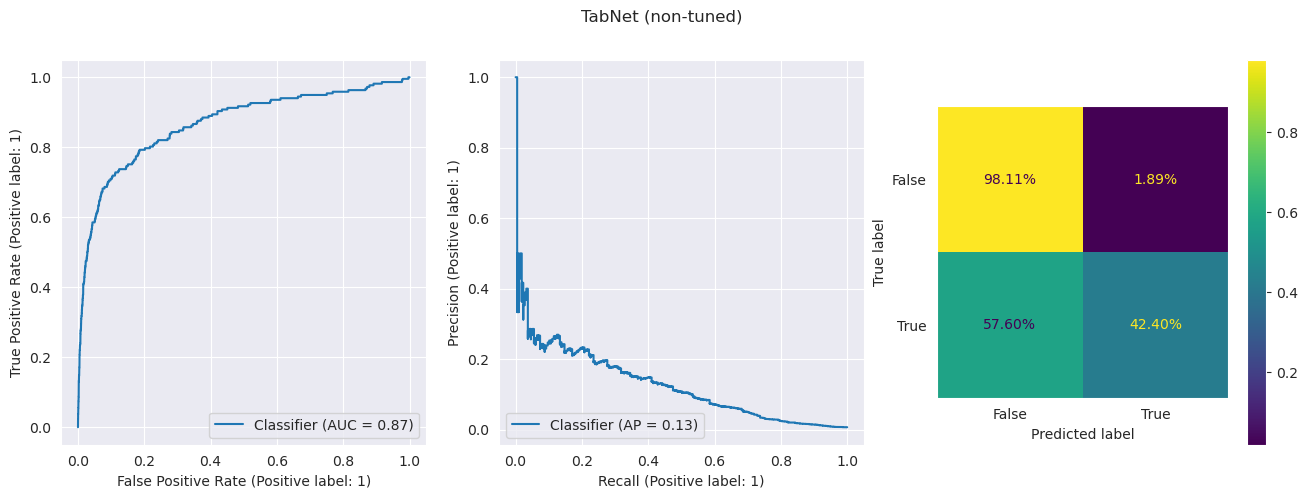

In [50]:
modelkey = "TabNet"
model = TabNetClassifier(**tabnet_params)
model.fit(
    X_train=X_train_tn,
    y_train=y_train_tn,
    eval_set=[(X_train_tn, y_train_tn), (X_valid_tn, y_valid_tn)],
    eval_name=["train", "valid"],
    eval_metric=["auc"],
    max_epochs=100,
    patience=tabnet_patience,
    # batch_size=512,
    # virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
)

Notebook.MODELS[modelkey] = model

Notebook.EVAL_RESULTS[modelkey] = evaluate(
    model,
    X_test.to_numpy(),
    y_test,
    "TabNet (non-tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_tabnet.png" if Notebook.SAVE_IMAGES else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


Accuracy  Precision   Recall  F1 Score  F2 Score       AUC       AUC_CI
Model  0.816387   0.028371  0.78341  0.054759  0.123907  0.866786  0.836-0.896

array([[25925,  5822],
       [   47,   170]])

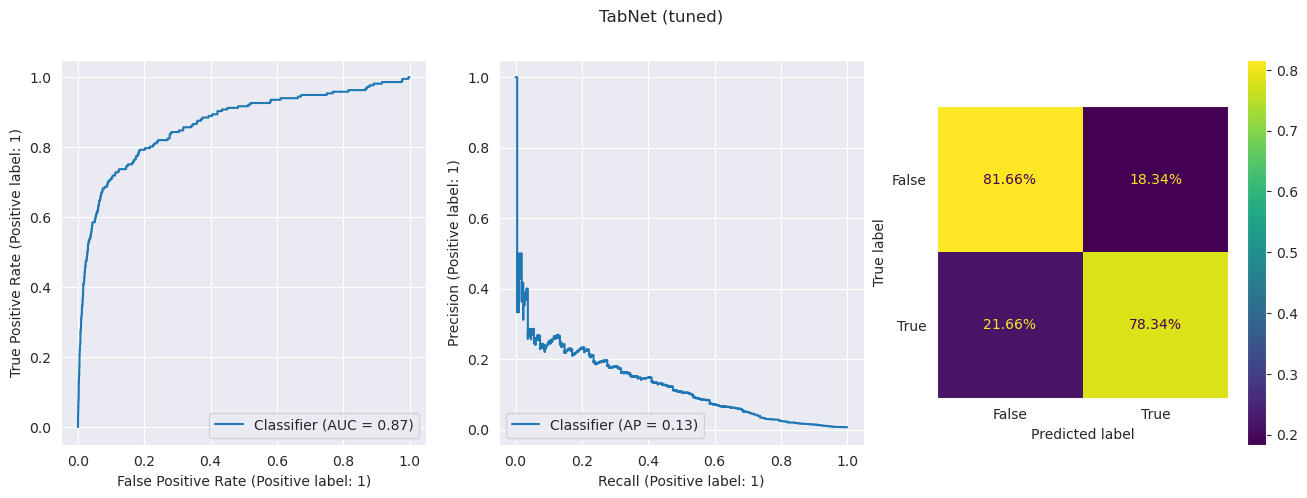

In [51]:
threshold = get_threshold(
    y_test, model.predict_proba(X_test.to_numpy())[:, 1], target=0.785
)

# Create predictions on the test set, using this new threshold
y_pred_proba = model.predict_proba(X_test.to_numpy())[:, 1]
y_pred = np.where(y_pred_proba > threshold, 1, 0)

Notebook.TUNED_RESULTS[modelkey] = evaluate_from_pred(
    y_test,
    y_pred,
    y_pred_proba,
    plot_title="TabNet (tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_thresholded_tabnet.png"
    if Notebook.SAVE_IMAGES
    else None,
)


Mortality


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.814291   0.012183  0.811111  0.024005  0.057462  0.883338   

            AUC_CI  
Model  0.839-0.921

array([[25955,  5919],
       [   17,    73]])

Critical Care


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.814885    0.01769  0.773723   0.03459   0.08104  0.857198   

            AUC_CI  
Model  0.815-0.897

array([[25941,  5886],
       [   31,   106]])

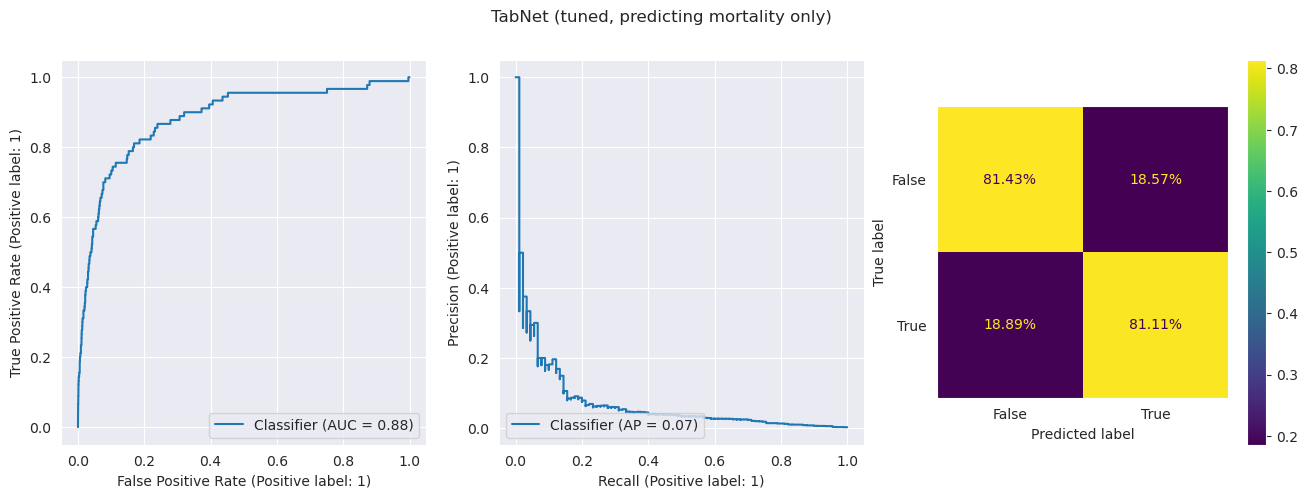

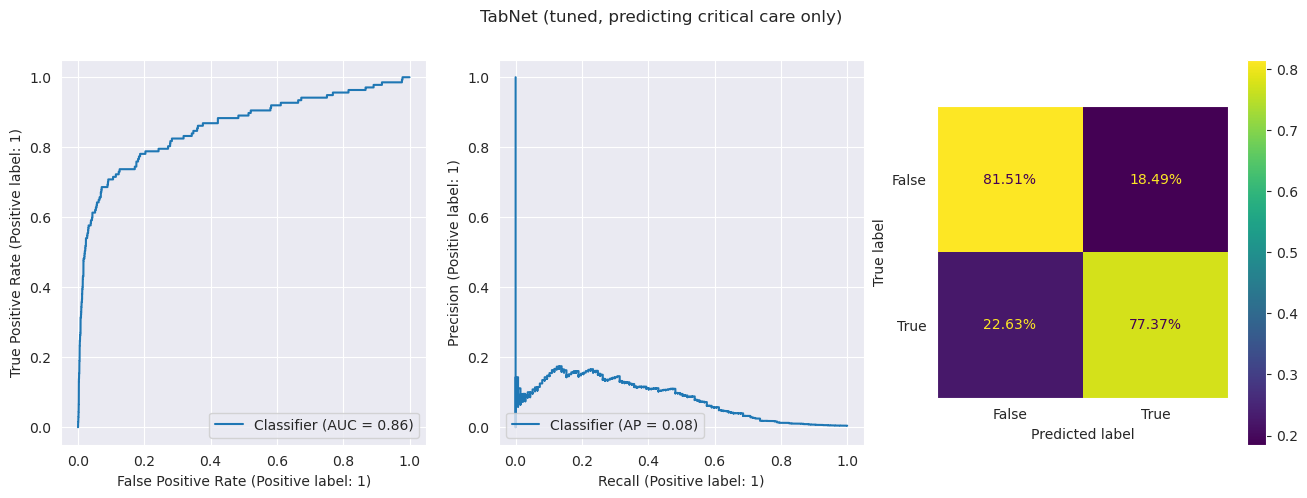

In [52]:
print("Mortality")
Notebook.MORTALITY_RESULTS[modelkey] = evaluate_from_pred(
    y_test_mortality,
    y_pred,
    y_pred_proba,
    plot_title="TabNet (tuned, predicting mortality only)",
    save=f"{Notebook.IMAGE_DIR}/eval_mortality_thresholded_tabnet.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)

print("Critical Care")
Notebook.CRITICALCARE_RESULTS[modelkey] = evaluate_from_pred(
    y_test_criticalcare,
    y_pred,
    y_pred_proba,
    plot_title="TabNet (tuned, predicting critical care only)",
    save=f"{Notebook.IMAGE_DIR}/eval_criticalcare_thresholded_tabnet.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


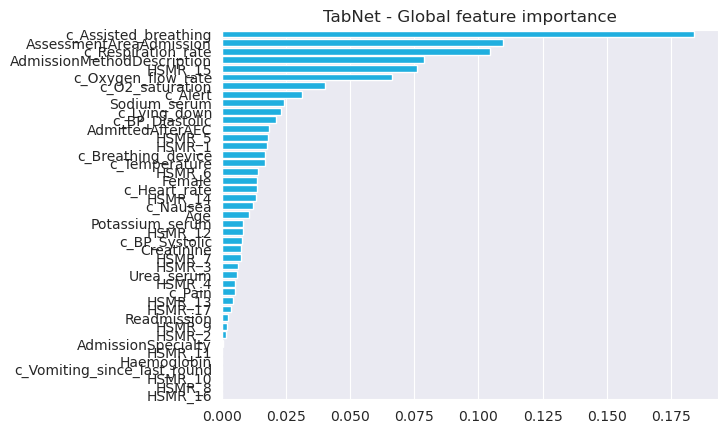

In [53]:
sorted_idx = model.feature_importances_.argsort()[::-1]
fig = sns.barplot(
    x=model.feature_importances_[sorted_idx],
    y=X_train.columns[sorted_idx],
    color="deepskyblue",
)
fig.set_title("TabNet - Global feature importance")

if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/global_weights_tabnet.png", bbox_inches="tight")



In [54]:
X_test_tn_shap = shap.sample(X_test.to_numpy(), 10000)
explainer = shap.KernelExplainer(model.predict_proba, np.concatenate((shap.sample(X_train_tn, 100), shap.sample(X_train_tn[y_train_tn], 100))))
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    shap_values = explainer.shap_values(X_test_tn_shap, nsamples=50)

Notebook.EXPLAINERS[modelkey] = (explainer, shap_values)

shap.summary_plot(
    shap_values[1],
    X_test_tn_shap,
    feature_names=X_test.columns,
    show=False,
    max_display=Notebook.SHAP_PLOTS_MAXDISPLAY,
    plot_type="dot",
)
plt.title("TabNet (estimated)")

if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/shap_swarm_tabnet.png", bbox_inches="tight")


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/10000 [00:00<?, ?it/s]

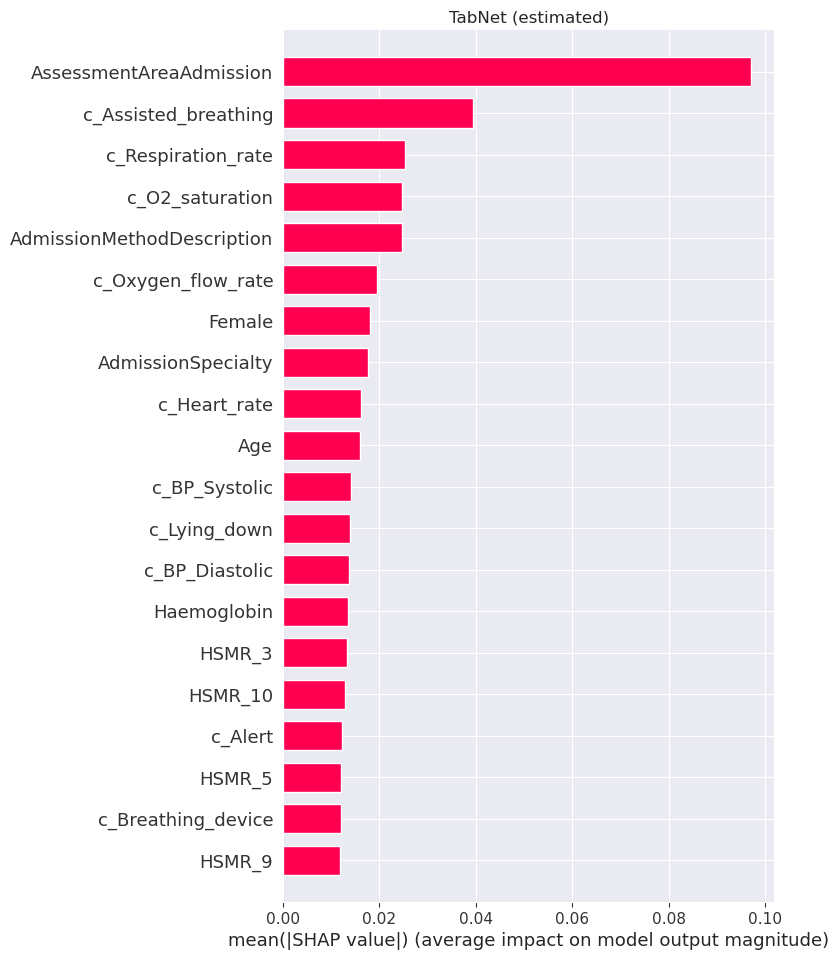

In [55]:
shap.summary_plot(
    shap_values[1],
    X_test_tn_shap,
    feature_names=X_test.columns,
    show=False,
    max_display=Notebook.SHAP_PLOTS_MAXDISPLAY,
    plot_type="bar",
    color=shap.plots.colors.red_rgb,
)
plt.title("TabNet (estimated)")

if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/shap_bar_tabnet.png", bbox_inches="tight")


In [56]:
if Notebook.SAVE_MODELS:
    with open(f"{Notebook.MODEL_DIR}/models.bin", "wb") as file:
        pickle.dump(Notebook.MODELS, file)

    with open(f"{Notebook.MODEL_DIR}/explainers.bin", "wb") as file:
        pickle.dump(Notebook.EXPLAINERS, file)


## Comparisons

### Scores

#### Pre-tuning scores

In [57]:
pd.concat(
    [results[0].assign(Model=key) for key, results in Notebook.EVAL_RESULTS.items()]
).set_index("Model")



Accuracy  Precision    Recall  F1 Score  \
Model                                                                      
Baseline (NEWS)                  0.979539   0.129032  0.350230  0.188586   
Logistic Regression (NEWS only)  0.866162   0.034182  0.686636  0.065122   
Logistic Regression              0.978319   0.163842  0.534562  0.250811   
Random Forest                    0.959517   0.116180  0.751152  0.201235   
XGBoost                          0.813102   0.032635  0.926267  0.063049   
LightGBM                         0.933675   0.081022  0.847926  0.147910   
Isolation Forest                 0.926230   0.047740  0.520737  0.087461   
TabNet                           0.977318   0.132948  0.423963  0.202420   

                                 F2 Score       AUC       AUC_CI  
Model                                                             
Baseline (NEWS)                  0.260810  0.837290  0.805-0.868  
Logistic Regression (NEWS only)  0.142529  0.837522  0.804-0.869  
Logistic Regression              0.368020  0.920145  0.898-0.941  
Random Forest                    0.358873  0.946424  0.930-0.961  
XGBoost                          0.143020  0.938709  0.918-0.957  
LightGBM                         0.293087  0.945610  0.927-0.962  
Isolation Forest                 0.174652  0.864062  0.838-0.888  
TabNet                           0.294872  0.866786  0.836-0.896

#### Post-tuning scores

In [58]:
pd.concat(
    [results[0].assign(Model=key) for key, results in Notebook.TUNED_RESULTS.items()]
).set_index("Model")



Accuracy  Precision    Recall  F1 Score  \
Model                                                                      
Logistic Regression (NEWS only)  0.534382   0.012498  0.866359  0.024641   
Logistic Regression              0.854023   0.038581  0.857143  0.073839   
Random Forest                    0.929076   0.075041  0.834101  0.137695   
XGBoost                          0.301308   0.009449  0.981567  0.018718   
LightGBM                         0.932518   0.079723  0.847926  0.145743   
Isolation Forest                 0.598455   0.015065  0.903226  0.029636   
TabNet                           0.816387   0.028371  0.783410  0.054759   

                                 F2 Score       AUC       AUC_CI  
Model                                                             
Logistic Regression (NEWS only)  0.059082  0.837522  0.804-0.869  
Logistic Regression              0.163473  0.920145  0.898-0.941  
Random Forest                    0.275915  0.946424  0.930-0.961  
XGBoost                          0.045493  0.938709  0.918-0.957  
LightGBM                         0.289673  0.945610  0.927-0.962  
Isolation Forest                 0.070615  0.864062  0.838-0.888  
TabNet                           0.123907  0.866786  0.836-0.896

### ROC

In [59]:
roc_dict, pr_dict = (
    {key: val[1] for key, val in Notebook.EVAL_RESULTS.items()},
    {key: val[2] for key, val in Notebook.EVAL_RESULTS.items()},
)



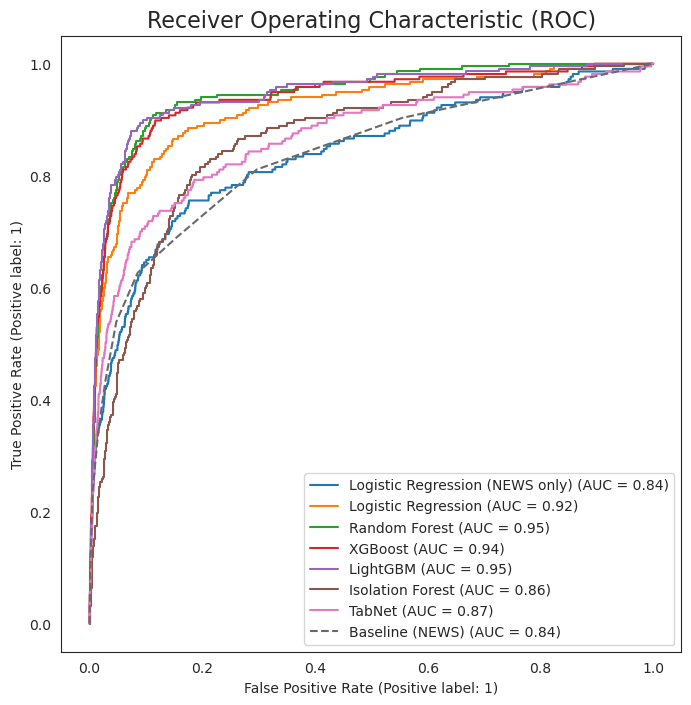

In [60]:
joint_plot(
    roc_dict,
    filename=f"{Notebook.IMAGE_DIR}/combined_roc_curve"
    if Notebook.SAVE_IMAGES
    else None,
    ax=None,
    title="Receiver Operating Characteristic (ROC)",
)


### Precision-Recall

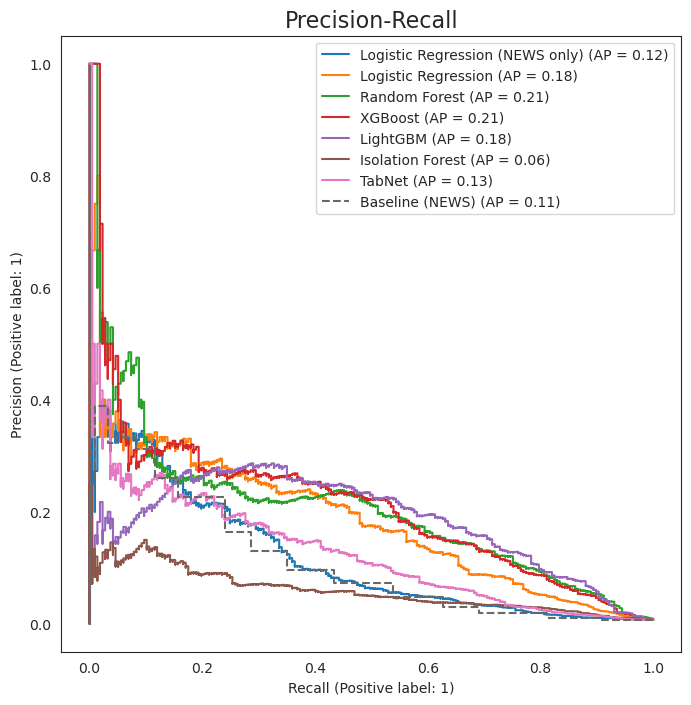

In [61]:
joint_plot(
    pr_dict,
    filename=f"{Notebook.IMAGE_DIR}/combined_pr_curve"
    if Notebook.SAVE_IMAGES
    else None,
    ax=None,
    title="Precision-Recall",
    legend_location="upper right",
)


### Side-by-side

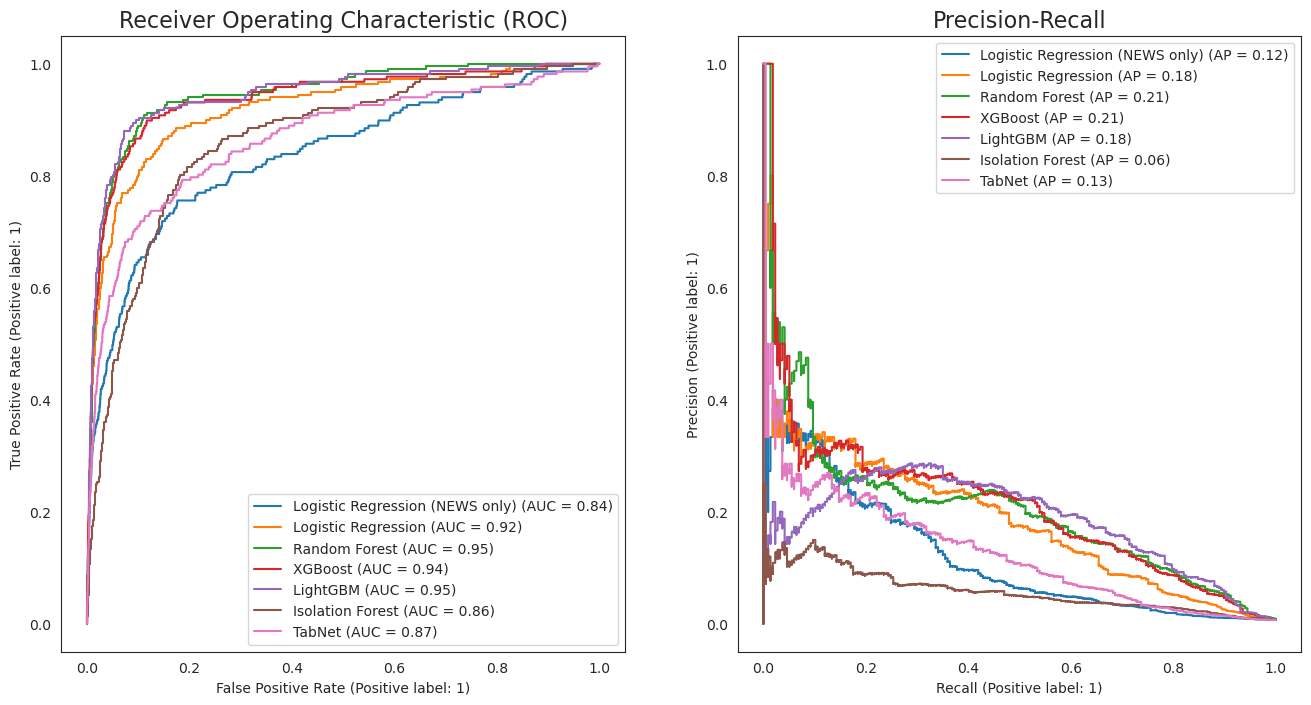

In [62]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
joint_plot(
    pr_dict,
    ax=ax[1],
    title="Precision-Recall",
    legend_location="upper right",
    plot_baseline=False,
)
joint_plot(
    roc_dict,
    ax=ax[0],
    title="Receiver Operating Characteristic (ROC)",
    plot_baseline=False,
)

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/combined_curves_no_baseline.png", bbox_inches="tight"
    )



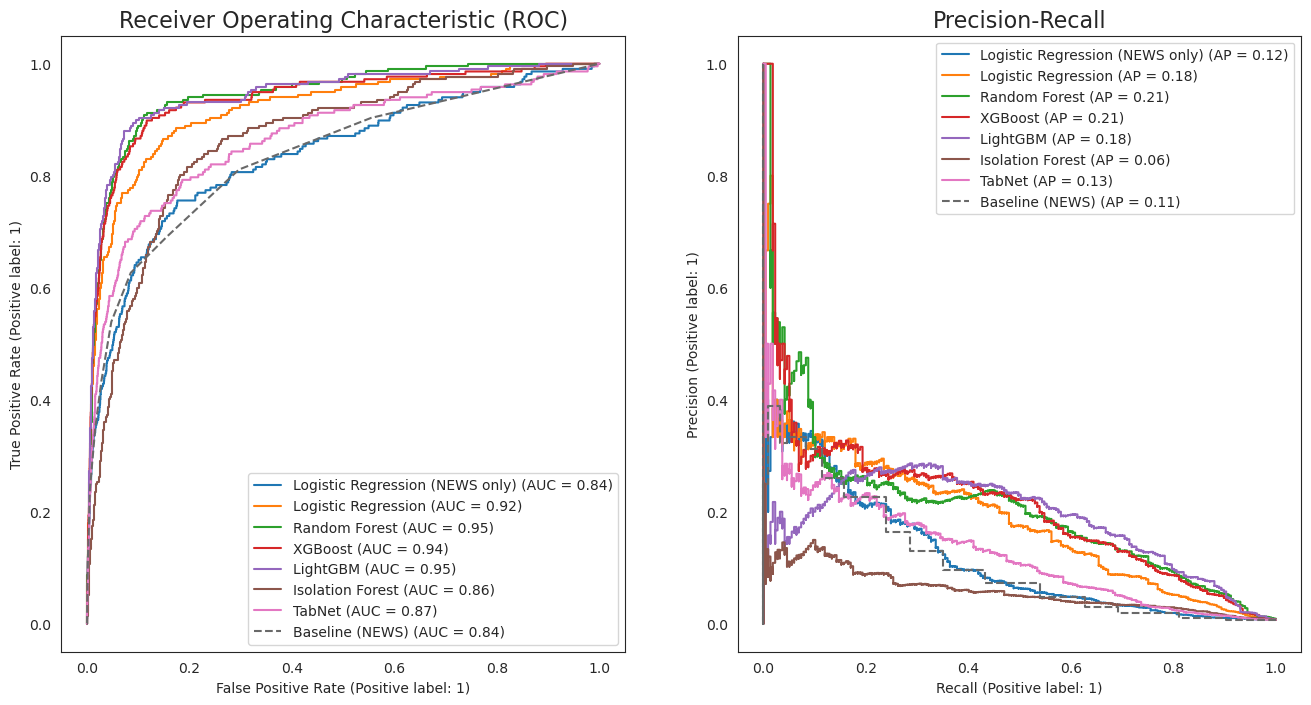

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
joint_plot(
    pr_dict, ax=ax[1], title="Precision-Recall", legend_location="upper right",
)
joint_plot(
    roc_dict, ax=ax[0], title="Receiver Operating Characteristic (ROC)",
)

if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/combined_curves.png", bbox_inches="tight")


### SHAP Explanations (Setup - skip to next section)

In [64]:
y_preds = pd.DataFrame(
    {
        key: model.predict(
            {
                "LightGBM": X_test,
                "Isolation Forest": X_test_if,
                "TabNet": X_test.to_numpy(),
                "XGBoost": X_test,
                "Random Forest": X_test,
                "Logistic Regression": X_test,
            }[key]
        )
        for key, model in Notebook.MODELS.items()
        if key != "Logistic Regression (NEWS only)"
    }
)

candidates = y_preds[y_preds.all(axis=1)].index

patient = candidates[0]
patient_data = X_test.iloc[patient].apply(
    lambda x: f"{x:.2f}" if type(x) == np.float64 else x
)
patient_data_if = X_test_if.iloc[patient].copy()
patient_data_if.update(X_test.iloc[patient])

explanations = {
    modelkey: shap_values[patient]
    for modelkey, (_, shap_values) in Notebook.EXPLAINERS.items()
    if not modelkey in ["TabNet", "Logistic Regression (NEWS only)"]
}
for _ in explanations.keys():
    if len(explanations[_].shape) > 1:
        explanations[_] = explanations[_][:, 1]

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")

    tabnet_explainer = Notebook.EXPLAINERS["TabNet"][0]
    explanations["TabNet"] = shap.Explanation(
        tabnet_explainer.shap_values(X_test.to_numpy()[patient])[1],
        data=patient_data.values,
        base_values=tabnet_explainer.expected_value[1],
        feature_names=patient_data.index,
    )



### SHAP Force Plots

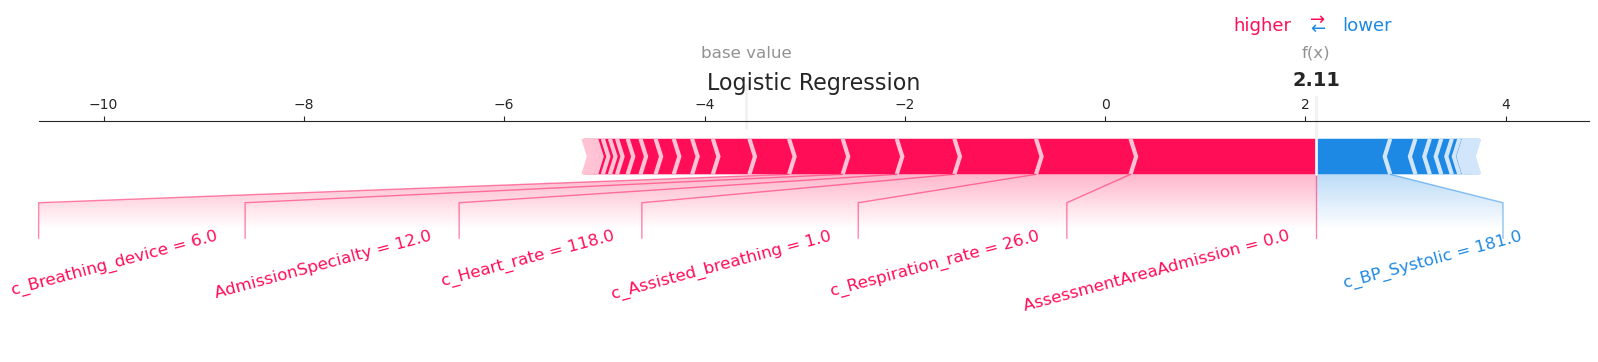

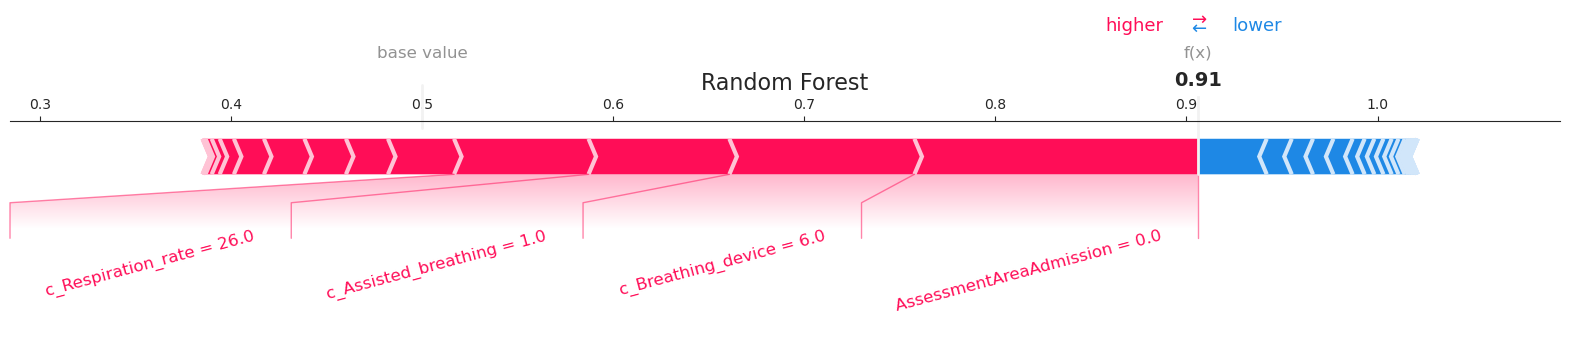

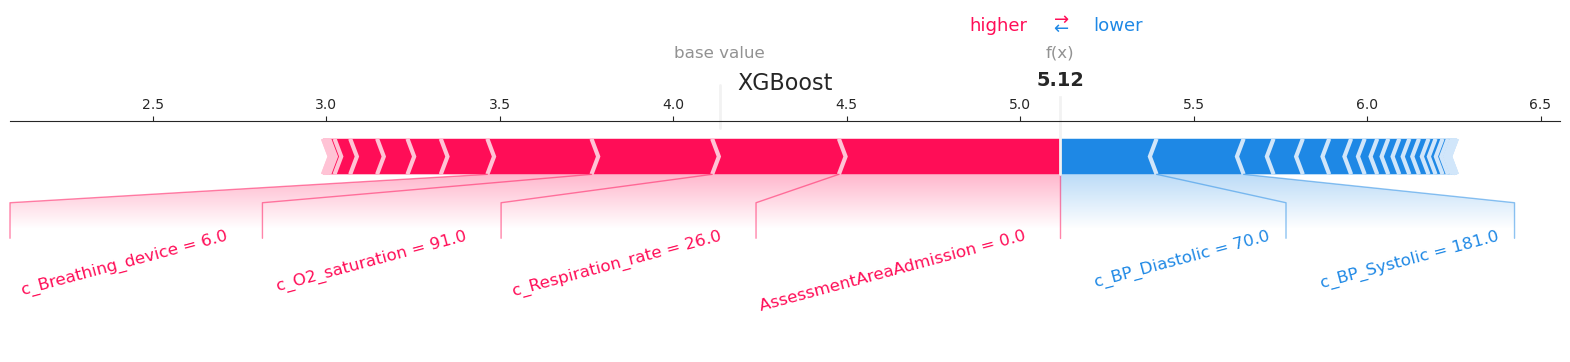

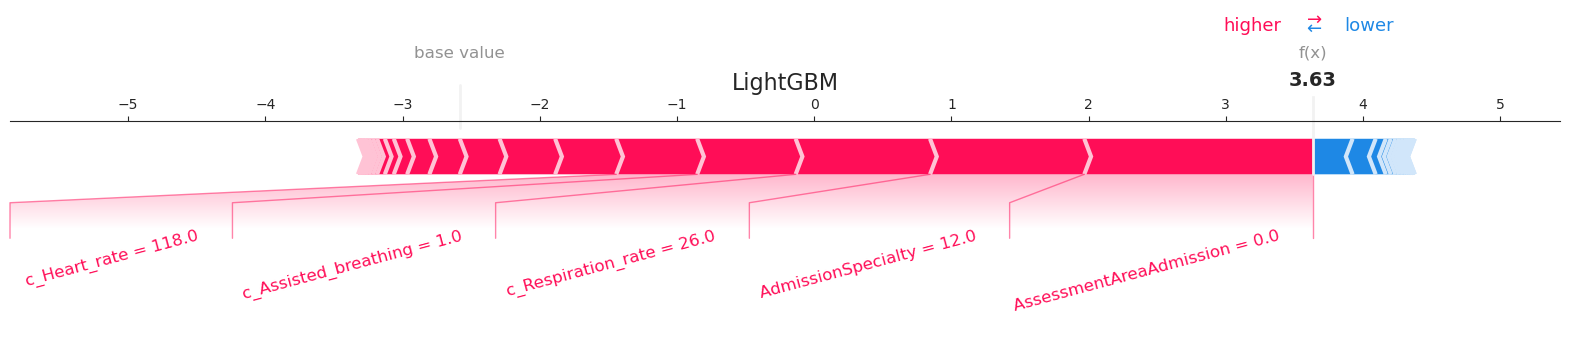

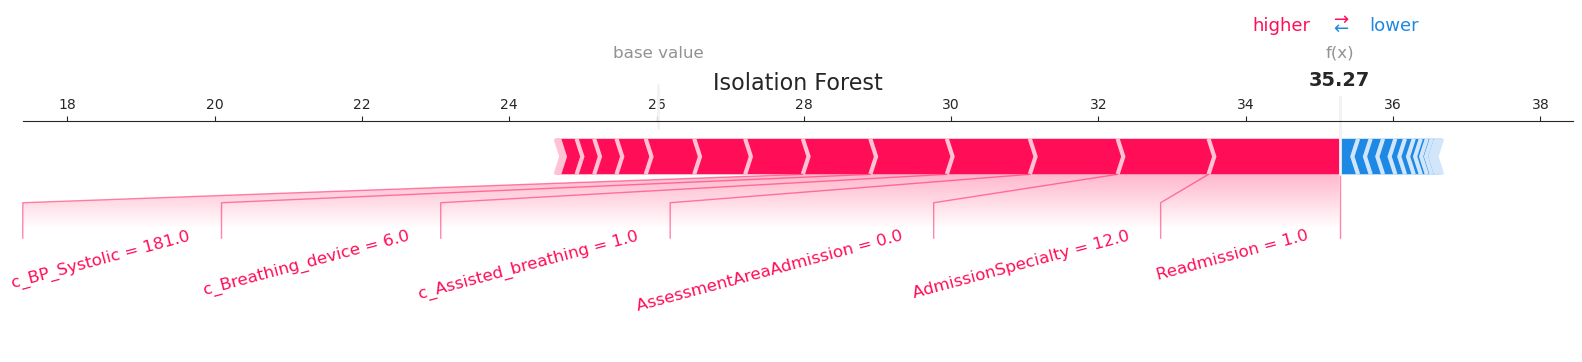

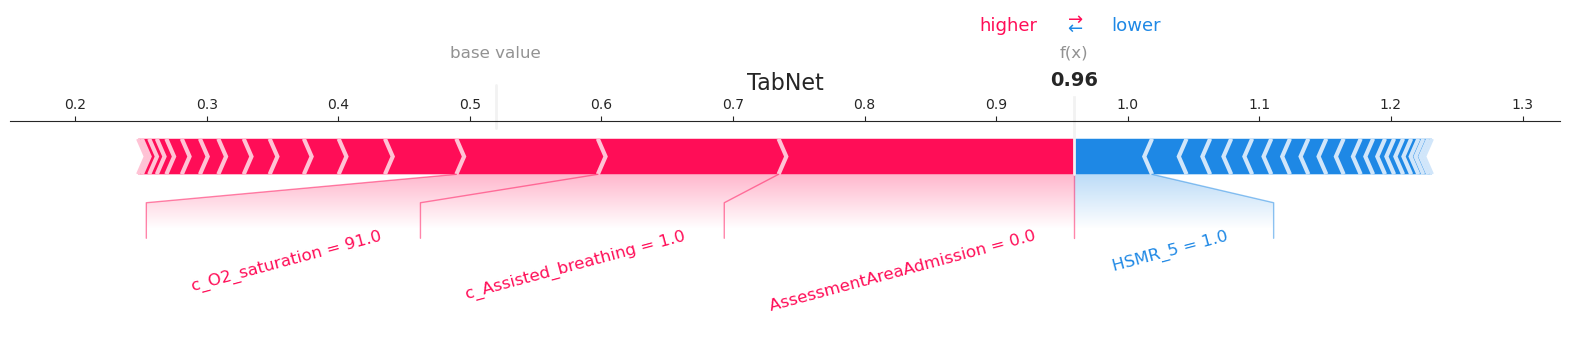

In [65]:
sns.set_style("white")
plt.rc("axes", titlesize=16)
for modelkey, explanation in explanations.items():
    patient_to_use = patient_data if modelkey != "Isolation Forest" else patient_data_if

    explanation = shap.Explanation(explanation)
    explanation.data = patient_to_use.values

    fig = shap.plots.force(
        explanation,
        feature_names=patient_to_use.index,
        matplotlib=True,
        contribution_threshold=0.08,
        show=False,
        text_rotation=15,
    )

    plt.title(modelkey)
    display(fig)

    if Notebook.SAVE_IMAGES:
        plt.savefig(
            f"{Notebook.IMAGE_DIR}/comaprison_force_plot_{modelkey.replace(' ','')}.png",
            bbox_inches="tight",
        )

    plt.clf()

sns.set_style("darkgrid")



### Mortality-only Results

In [66]:
pd.concat(
    [
        results[0].assign(Model=key)
        for key, results in Notebook.MORTALITY_RESULTS.items()
    ]
).set_index("Model")



Accuracy  Precision    Recall  F1 Score  \
Model                                                                      
Baseline (NEWS)                  0.982699   0.106961  0.700000  0.185567   
Logistic Regression (NEWS only)  0.532036   0.005784  0.966667  0.011499   
Logistic Regression              0.851239   0.016179  0.866667  0.031765   
Random Forest                    0.926167   0.029436  0.788889  0.056755   
XGBoost                          0.297522   0.003948  0.988889  0.007865   
LightGBM                         0.929921   0.034229  0.877778  0.065888   
Isolation Forest                 0.595420   0.006457  0.933333  0.012824   
TabNet                           0.814291   0.012183  0.811111  0.024005   

                                 F2 Score       AUC       AUC_CI  
Model                                                             
Baseline (NEWS)                  0.331928  0.952171  0.926-0.973  
Logistic Regression (NEWS only)  0.028243  0.931502  0.893-0.964  
Logistic Regression              0.075275  0.933575  0.904-0.959  
Random Forest                    0.128066  0.935643  0.905-0.961  
XGBoost                          0.019431  0.944197  0.916-0.965  
LightGBM                         0.148051  0.948336  0.921-0.970  
Isolation Forest                 0.031414  0.886767  0.844-0.923  
TabNet                           0.057462  0.883338  0.839-0.921

In [67]:
roc_dict, pr_dict = (
    {key: val[1] for key, val in Notebook.MORTALITY_RESULTS.items()},
    {key: val[2] for key, val in Notebook.MORTALITY_RESULTS.items()},
)

joint_plot(
    roc_dict,
    filename=f"{Notebook.IMAGE_DIR}/combined_roc_curve_mortality"
    if Notebook.SAVE_IMAGES
    else None,
    ax=None,
    title="Receiver Operating Characteristic (predicting mortality only)",
)

joint_plot(
    pr_dict,
    filename=f"{Notebook.IMAGE_DIR}/combined_pr_curve_mortality"
    if Notebook.SAVE_IMAGES
    else None,
    ax=None,
    title="Precision-Recall (predicting mortality only)",
    legend_location="upper right",
)

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
joint_plot(
    pr_dict, ax=ax[1], title="Precision-Recall", legend_location="upper right",
)
joint_plot(
    roc_dict, ax=ax[0], title="Receiver Operating Characteristic (ROC)",
)

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/combined_curves_mortality.png", bbox_inches="tight"
    )


### Critical care-only results

In [68]:
roc_dict, pr_dict = (
    {key: val[1] for key, val in Notebook.CRITICALCARE_RESULTS.items()},
    {key: val[2] for key, val in Notebook.CRITICALCARE_RESULTS.items()},
)

joint_plot(
    roc_dict,
    filename=f"{Notebook.IMAGE_DIR}/combined_roc_curve_criticalcare"
    if Notebook.SAVE_IMAGES
    else None,
    ax=None,
    title="Receiver Operating Characteristic (predicting critical care only)",
)

joint_plot(
    pr_dict,
    filename=f"{Notebook.IMAGE_DIR}/combined_pr_curve_criticalcare"
    if Notebook.SAVE_IMAGES
    else None,
    ax=None,
    title="Precision-Recall (predicting critical care only)",
    legend_location="upper right",
)

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
joint_plot(
    pr_dict, ax=ax[1], title="Precision-Recall", legend_location="upper right",
)
joint_plot(
    roc_dict, ax=ax[0], title="Receiver Operating Characteristic (ROC)",
)

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/combined_curves_criticalcare.png", bbox_inches="tight"
    )
